# Setup

In [1]:
!brew install libomp    # might help if getting an OSERROR: dlopen...

To reinstall 17.0.6, run:
  brew reinstall libomp


In [2]:
# !pip install prettytable

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
from flaml import AutoML
from sklearn.ensemble import HistGradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor

from lightgbm import LGBMRegressor
from prettytable import PrettyTable
import sys  
import os
root_path = os.path.realpath('/..')
sys.path.insert(0, root_path)
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

from tw_experimentation.variance_reduction.diff_in_means import DifferenceInMeans
from tw_experimentation.variance_reduction.cuped import CUPED, multiple_CUPEDs, MultivariateCUPED
from tw_experimentation.variance_reduction.utils import create_pretty_table, query_snowflake, bootstrap_generator, subsample_generator, bootstrap_data, subsample_data, aaify, add_synthetic_effect, diff_in_means
from tw_experimentation.variance_reduction.mlrate import MLRATE, AltMLRATE
from tw_experimentation.variance_reduction.cupac import CUPAC
from tw_experimentation.variance_reduction.doubly_robust import DoublyRobustEstimator
from tw_experimentation.variance_reduction.evaluation_pipeline import VREvaluation, VREvaluationAll, VREvaluationGrid
from tw_experimentation.variance_reduction.multivariate_regression import MultivariateRegression, MultivariateRegressionAdjusted

# increase globally font size of matplotlib plots
plt.rcParams.update({'font.size': 12})

# increase globally font size of matplotlib plots titles
plt.rcParams.update({'axes.titlesize': 16})


In [4]:
def dgp(n=2000, p=10, linear=True, constant=True):
    """DGP from https://github.com/muratunalphd/Blog-Posts/blob/main/variance-reduction-methods/MLRATE.ipynb"""
        
    Xmat = np.random.multivariate_normal(np.zeros(p), np.eye(p), size=n).astype('float32')

    T = np.random.binomial(1, 0.5, n).astype('int8')

    col_list = ['X' + str(x) for x in range(1,(p+1))]

    df = pd.DataFrame(Xmat, columns = col_list)
    
    # functional form of the covariates
    if linear:
        B = 225 + 50*df['X1'] + 5*df['X2'] + 20*(df['X3']-0.5) + 10*df['X4'] + 5*df['X5']
    else:
        B = 225 + 50*df['X1'] + 5*np.sin(np.pi*df['X1']*df['X2'] ) + 10*(df['X3']-0.5)**2 + 10*df['X4']**2 + 5*df['X5']**3
    
    # constant ate or non-constant
    tau = 1.8 if constant else 5*df['X1'] + 5*np.log(1 + np.exp(df['X2']))
    
    # Y = (B + tau*T + np.random.normal(0,25,n)).astype('float32')
    Y = (B + tau*T + np.random.normal(0,25,n)).astype('float32')
        
    df['T'] = T
    df['Y'] = Y    
    return df

In [5]:
example_data = dgp(10000, 10)

In [6]:
pre_exp_example_data = dgp(10000,10)
pre_exp_example_data = pre_exp_example_data.loc[pre_exp_example_data['T']==0]

# Variance Reduction methods

We implement the following methods in classes:
- `DifferenceInMeans` - the baseline method, no variance reduction
- `MultivariateRegression` - multivariate regression
- `MultivariateRegressionAdjustment` - multivariate regression adjustment
- `CUPED` - CUPED
- `MultivariateCUPED` - multivariate CUPED
- `CUPAC` - CUPAC
- `MLRATE` - MLRATE
- `DoublyRobustEstimator` - doubly robust estimator

All these methods are children of an abstract `VarianceReductionMethod` class, which provides a common interface for all methods. This allows for easy comparison of the methods and for easy evaluation of their performance.

To perform estimation we first instantiate a method:

In [7]:
estimator = MultivariateCUPED()

And then we can apply the method to data:

In [8]:
estimator = estimator.fit(data=example_data,
                          treatment_column='T',
                          target_column='Y',
                          covariate_columns=['X1', 'X2', 'X3'])


... and extract statistics of interest:

In [9]:
print("Estimate:", "%.3f" % estimator.estimate)
print("CI Lower:", "%.3f" % estimator.conf_int_95[0])
print("CI Upper:", "%.3f" % estimator.conf_int_95[1])
print("P-value:", "%.3f" % estimator.p_value)
print("Variance Reduction Rate:", "%.3f" % estimator.variance_reduction_rate)

Estimate: 2.042
CI Lower: 0.967
CI Upper: 3.116
P-value: 0.000
Variance Reduction Rate: 0.797


Note that other method may require different parameters when calling the `fit` method.


Also note that, the methods assume that the data has been preprocessed such that it does not contain any missing values, the columns are numerical and the treatment columns is binary (0 -- control, 1 -- treatment).

# Evaluation of variance reduction methods

At the moment the library provides 3 evaluation tools:
- `VREvaluation` - for evaluating a single variance reduction method.
- `VREvaluationAll` - for evaluating and comparing multiple variance reduction methods.
- `VREvaluationGrid` - for evaluating and comparing multiple variance reduction methods on a grid of parameters.

## Evaluation of a single method

Performing an evaluation requires the definition of a method-parameters map:

In [10]:
MLRATE_params_map = {
    'MLRATE': {
        'K_splits': 2,
        'covariate_columns': ['X1', 'X6', 'X7', 'X8'],
        'model': ElasticNet,
        'model_init_config': {},
        'model_fit_config': {}
    }
}

Then we initialize the evaluator with the method we are interested in:

In [11]:
mlrate_evaluation = VREvaluation(MLRATE)

And we can proceed to run the evaluation:

In [12]:
mlrate_evaluation = mlrate_evaluation.run(data=example_data,
                                          treatment_column='T',
                                          target_column='Y',
                                          true_ate=diff_in_means(example_data, 'T', 'Y'),
                                          method_params_map=MLRATE_params_map,
                                          verbose=True,
                                          n_bootstrap=100)

Running MLRATE...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 58.61it/s]


We present the results of the evaluation in a table:

In [13]:
mlrate_evaluation.report()

,Method,Estimate,Estimate CI,Bias,Bias CI,p-value,p-value CI,Coverage Probability,Variance Reduction
0,MLRATE,2.219693,"(0.9251321727306654, 3.484750872268027)",-0.166095,"(-1.460655791136522, 1.0989629084008394)",0.024556,"(4.776801856896267e-07, 0.17805264147646374)",0.92,0.74143


... or in a plot:

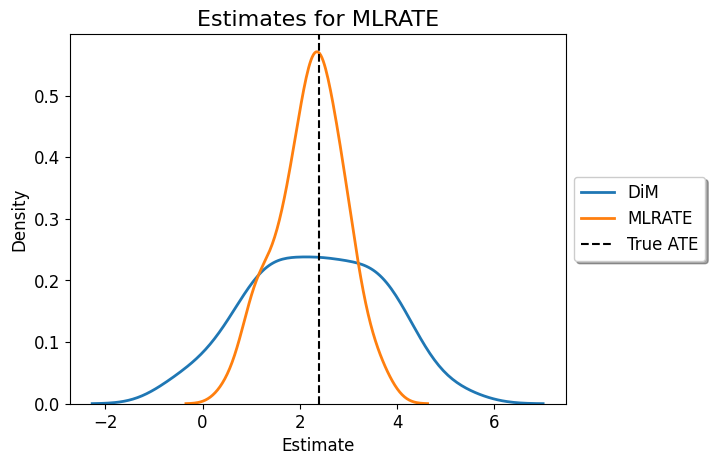

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Estimates for MLRATE'}, xlabel='Estimate', ylabel='Density'>)

In [14]:
mlrate_evaluation.plot(plot_what='estimates')

## Comparison of mutliple methods

The flow of evaluation and comparison of many variance reduction methods is same as for a single method with a few small differences.

As before we start with defining the method-parameters map

In [15]:
method_params_map = {

    'DifferenceInMeans': {
    },
    
    'CUPED': {
        'covariate_column': 'X1'
    },

    'MultivariateCUPED': {
        'covariate_columns': ['X1', 'X2', 'X5', 'X6']
    },

    'MultivariateRegression': {
        'covariate_columns': ['X1', 'X2', 'X5', 'X6']
    },

    'MultivariateRegressionAdjusted': {
        'covariate_columns': ['X1', 'X2', 'X5', 'X6']
    },

    'CUPAC': {
        'pre_experiment_data': pre_exp_example_data,
        'covariate_columns': ['X1', 'X2', 'X5', 'X6'],
        'model': LGBMRegressor,
        'model_init_config': {},
        'model_fit_config': {}
    },

    'MLRATE': {
        'K_splits': 2,
        'covariate_columns': ['X1', 'X2', 'X5', 'X6'],
        'model': LGBMRegressor,
        'model_init_config': {},
        'model_fit_config': {}
    },

    'DoublyRobustEstimator': {
        'covariate_columns': ['X1', 'X2', 'X5', 'X6'],
        'model_regression': LGBMRegressor
        
    }

}

Then we instantiate the appropriate class with all methods we wish to compare:

In [16]:
all_evaluation = VREvaluationAll([DifferenceInMeans,
                                 MultivariateRegression,
                                 MultivariateRegressionAdjusted,
                                 CUPED,
                                 MultivariateCUPED,
                                 CUPAC,
                                 MLRATE,
                                 DoublyRobustEstimator])

We perform the evaluation by calling `run_all`

In [17]:
all_evaluation = all_evaluation.run_all(data=example_data,
                                        treatment_column='T',
                                        target_column='Y',
                                        true_ate=diff_in_means(example_data, 'T', 'Y'),
                                        method_params_map=method_params_map,
                                        verbose=True,
                                        n_bootstrap=100)

Running DifferenceInMeans...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 404.79it/s]


Running MultivariateRegression...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 99.06it/s]


Running MultivariateRegressionAdjusted...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 63.78it/s]


Running CUPED...


 10%|████▏                                     | 10/100 [00:00<00:00, 94.30it/s]

[215.97181986  49.80177835]
[215.88984923  49.68831671]
[215.490263    50.06277908]
[215.6736286   49.68309446]
[215.25198236  49.98834158]
[215.59569335  49.61371951]
[216.16369029  50.05753286]
[215.65769538  49.61659872]
[215.52062953  50.10007675]
[215.8074545   49.72582337]
[216.10507187  49.74103149]
[215.70919659  50.5460778 ]
[215.63674055  49.58462974]
[215.78412558  50.27404014]
[216.13105379  49.46852618]
[215.66159782  49.85730984]
[215.12627084  49.57001048]
[216.58650247  49.68806186]
[215.58780311  49.49817547]
[215.27727474  49.54050158]


 30%|████████████▌                             | 30/100 [00:00<00:00, 94.97it/s]

[215.63396956  50.48294999]
[215.4948174   49.62099861]
[215.6234911   49.77656231]
[215.84656631  50.13678973]
[215.13138324  50.39336879]
[216.07968171  49.82500692]
[215.51441804  49.58188086]
[215.9146999   50.04001177]
[215.65973798  50.48899948]
[215.2310288   49.67777205]
[215.39735989  49.39866095]
[215.87123932  49.71781211]
[215.6692488   49.54691525]
[215.40451338  49.36046171]
[215.29757206  49.92567775]
[215.9359596   49.86908338]
[215.15385387  49.47746098]
[215.68642329  49.99640111]
[215.89048951  49.78993607]
[215.20047045  50.22930637]


 50%|█████████████████████                     | 50/100 [00:00<00:00, 95.88it/s]

[215.76802066  49.64288429]
[216.11035414  50.00686745]
[215.36770657  50.21829815]
[215.5815209   49.81625858]
[215.14434783  50.06041944]
[215.83991105  49.90255969]
[215.82197937  49.90268861]
[215.81036117  50.29353926]
[215.79602299  49.93314988]
[215.81632046  50.21333361]
[215.72769715  49.2566206 ]
[215.56387015  50.29379977]
[215.80187572  50.12050241]
[215.64118173  49.8958593 ]
[216.20948828  50.36214635]
[215.9448822   49.85787275]
[215.47521511  49.98595927]
[216.40185523  49.98217186]
[215.64875125  50.02335123]
[215.8727149   50.18261186]


 70%|█████████████████████████████▍            | 70/100 [00:00<00:00, 95.26it/s]

[215.22082113  50.06760387]
[215.10645975  49.8708062 ]
[215.62141632  50.20322723]
[215.83688154  49.90781159]
[216.20396114  49.41985154]
[215.49831213  50.67214739]
[216.10322296  50.32619208]
[215.98663503  49.67368119]
[215.64481086  49.74988013]
[215.33710594  50.12414649]
[215.51102329  49.74447142]
[215.61911687  50.31638276]
[214.9171478   49.50295973]
[215.16858369  49.78249679]
[215.23960709  49.86435753]
[216.03373611  49.9935103 ]
[215.93002791  50.02058238]
[215.26003004  49.17979332]
[215.5032641   49.62506343]
[215.15276465  49.37799455]


 90%|█████████████████████████████████████▊    | 90/100 [00:00<00:00, 96.64it/s]

[215.66606349  49.89612284]
[215.38976937  50.69253381]
[216.20778655  50.28644822]
[216.2750308   49.65342849]
[215.26215826  50.11174253]
[215.24470245  50.07534131]
[215.78515013  49.96869181]
[215.65942629  49.45095992]
[215.89590202  49.98780591]
[215.98363048  50.12003445]
[215.94678529  49.90272063]
[215.54404353  49.59964651]
[215.33616892  50.64414529]
[216.16791975  49.95242987]
[215.68128744  49.28407991]
[215.56103916  49.51448659]
[216.47493853  49.97395519]
[215.37202217  50.14243604]
[215.77145634  50.3286175 ]


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 95.90it/s]


[214.83490107  49.38239778]
Running MultivariateCUPED...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 128.72it/s]


Running CUPAC...


  1%|▍                                          | 1/100 [00:00<00:10,  9.26it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[4.30560489 0.98657395]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[6.70482822 0.97537635]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number o

  5%|██▏                                        | 5/100 [00:00<00:08, 11.43it/s]

[3.94209723 0.98515179]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[5.70290038 0.9782885 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[3.43811632 0.98641058]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the t

  7%|███                                        | 7/100 [00:00<00:08, 11.29it/s]

[5.22451563 0.9806573 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[4.85741505 0.98496737]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313


  9%|███▊                                       | 9/100 [00:00<00:10,  8.49it/s]

[6.29111391 0.97674608]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[2.15657205 0.99452659]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[5.16756979 0.98216878]


 11%|████▌                                     | 11/100 [00:01<00:09,  9.58it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[5.28827464 0.98318231]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[2.07353013 0.99615687]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number o

 15%|██████▎                                   | 15/100 [00:01<00:07, 11.13it/s]

[6.61427199 0.97462602]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[3.17545502 0.99179552]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[6.67271631 0.97642649]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the t

 17%|███████▏                                  | 17/100 [00:01<00:07, 11.59it/s]

[4.62643294 0.98366629]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[5.61945903 0.97641918]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[6.40183405 0.98023788]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the t

 21%|████████▊                                 | 21/100 [00:01<00:06, 11.49it/s]

[6.89204401 0.97252948]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[6.34281125 0.97412259]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[2.31548378 0.9953428 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the t

 23%|█████████▋                                | 23/100 [00:02<00:06, 11.32it/s]

[5.60701258 0.97809474]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[4.99967767 0.98195059]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[3.88389864 0.98862784]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the t

 27%|███████████▎                              | 27/100 [00:02<00:06, 11.80it/s]

[2.5685215  0.99076221]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[6.08254325 0.97927706]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[5.75416366 0.97713664]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the t

 29%|████████████▏                             | 29/100 [00:02<00:06, 11.45it/s]

[4.22089196 0.98629185]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[2.17087667 0.99539112]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[3.90879049 0.98431712]


 31%|█████████████                             | 31/100 [00:02<00:06, 10.97it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[7.35495826 0.96960471]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[5.44919367 0.97987325]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number o

 35%|██████████████▋                           | 35/100 [00:03<00:05, 11.52it/s]

[5.32817122 0.98040564]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[6.55369343 0.97401195]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[3.74863826 0.98718234]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the t

 37%|███████████████▌                          | 37/100 [00:03<00:05, 11.28it/s]

[3.67411194 0.98993308]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[6.85828987 0.97021644]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[3.94979512 0.98661612]


 39%|████████████████▍                         | 39/100 [00:03<00:05, 10.66it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[5.21496158 0.98259919]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[3.09325825 0.98912845]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number o

 41%|█████████████████▏                        | 41/100 [00:03<00:05, 11.13it/s]

[5.74399268 0.97913888]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[5.44511542 0.98196174]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313


 43%|██████████████████                        | 43/100 [00:04<00:08,  6.74it/s]

[3.5313077  0.98802437]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313


 44%|██████████████████▍                       | 44/100 [00:04<00:09,  5.85it/s]

[3.89124423 0.985974  ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313


 46%|███████████████████▎                      | 46/100 [00:04<00:09,  5.51it/s]

[3.76257965 0.98576682]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[4.07273774 0.9877499 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313


 47%|███████████████████▋                      | 47/100 [00:05<00:11,  4.65it/s]

[4.84171283 0.98387785]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313


 50%|█████████████████████                     | 50/100 [00:05<00:08,  6.13it/s]

[2.14703929 0.99588766]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[4.01421211 0.98671399]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[3.41834036 0.99138041]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the t

 52%|█████████████████████▊                    | 52/100 [00:05<00:06,  7.64it/s]

[5.72137355 0.97828307]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[2.19712102 0.99427297]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[3.68560508 0.98866994]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the t

 56%|███████████████████████▌                  | 56/100 [00:06<00:04,  9.43it/s]

[4.28962975 0.98508975]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[4.09313341 0.98922795]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[3.73912145 0.9894465 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the t

 58%|████████████████████████▎                 | 58/100 [00:06<00:04, 10.08it/s]

[4.58876513 0.98281817]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[5.04230099 0.98470909]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[3.34897227 0.98885304]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the t

 62%|██████████████████████████                | 62/100 [00:06<00:03, 10.79it/s]

[4.32431586 0.98578209]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[3.74475049 0.98566562]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[4.16706438 0.98341294]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the t

 64%|██████████████████████████▉               | 64/100 [00:06<00:03, 10.94it/s]

[3.63067507 0.98814719]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[3.81176812 0.98843146]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[7.51770336 0.97267829]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the t

 68%|████████████████████████████▌             | 68/100 [00:07<00:02, 11.88it/s]

[0.09078622 1.00467463]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[3.02810545 0.99306849]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[5.7371303  0.97967309]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the t

 70%|█████████████████████████████▍            | 70/100 [00:07<00:03,  8.64it/s]

[4.94601313 0.98156372]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[2.93024706 0.99037292]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313


 72%|██████████████████████████████▏           | 72/100 [00:07<00:03,  8.47it/s]

[5.14507177 0.98142364]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[1.71971333 0.99593981]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[5.35183888 0.97758081]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the t

 75%|███████████████████████████████▌          | 75/100 [00:08<00:02,  9.12it/s]

[4.17426884 0.98409516]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[4.55659122 0.98151805]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313


 78%|████████████████████████████████▊         | 78/100 [00:08<00:02,  9.61it/s]

[4.21403245 0.987044  ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[4.41197809 0.98713035]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[6.94118559 0.9708313 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the t

 80%|█████████████████████████████████▌        | 80/100 [00:08<00:01, 10.03it/s]

[5.77318553 0.97735815]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[5.96223092 0.97542378]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[4.18104646 0.98590694]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the t

 84%|███████████████████████████████████▎      | 84/100 [00:08<00:01, 10.77it/s]

[0.79792847 1.00049362]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[3.65485148 0.9908883 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[6.09767546 0.97969685]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the t

 86%|████████████████████████████████████      | 86/100 [00:09<00:01, 11.10it/s]

[2.89066163 0.9903894 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[4.39075565 0.98195161]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[4.04452915 0.98658093]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the t

 90%|█████████████████████████████████████▊    | 90/100 [00:09<00:00, 11.57it/s]

[6.01806538 0.97795374]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[3.93441756 0.98839264]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[3.3333006  0.99240404]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the t

 92%|██████████████████████████████████████▋   | 92/100 [00:09<00:00, 11.90it/s]

[4.83329182 0.98393436]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[4.54464696 0.98426731]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[0.8285073 1.0006295]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the tra

 94%|███████████████████████████████████████▍  | 94/100 [00:09<00:00, 12.39it/s]

[3.96172513 0.98882681]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[6.9291197 0.9735192]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313


 96%|████████████████████████████████████████▎ | 96/100 [00:09<00:00, 11.29it/s]

[6.64252782 0.97393405]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[3.62088028 0.99117666]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313


 98%|█████████████████████████████████████████▏| 98/100 [00:10<00:00,  9.61it/s]

[3.04630902 0.99035538]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313
[2.39749651 0.99466877]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 4
[LightGBM] [Info] Start training from score 213.407313


100%|█████████████████████████████████████████| 100/100 [00:10<00:00,  9.31it/s]


[5.54959135 0.97542422]
Running MLRATE...


  0%|                                                   | 0/100 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.711604
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 216.002974


  1%|▍                                          | 1/100 [00:00<00:38,  2.59it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.430214
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 216.176396


  3%|█▎                                         | 3/100 [00:00<00:28,  3.44it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.323293
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 216.214296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

  4%|█▋                                         | 4/100 [00:01<00:22,  4.22it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.299824
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.196109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set

  6%|██▌                                        | 6/100 [00:01<00:17,  5.40it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 214.515425
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 216.622433
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

  8%|███▍                                       | 8/100 [00:01<00:14,  6.25it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.828429
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.274664
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 10%|████▏                                     | 10/100 [00:01<00:13,  6.59it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.282100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.834677
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 12%|█████                                     | 12/100 [00:02<00:13,  6.76it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 216.155206
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 214.852558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 13%|█████▍                                    | 13/100 [00:02<00:13,  6.60it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 214.666259
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.394540
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set

 15%|██████▎                                   | 15/100 [00:02<00:12,  6.55it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 216.649275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 214.816812
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 16%|██████▋                                   | 16/100 [00:02<00:12,  6.47it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.821060
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 213.792944
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 18%|███████▌                                  | 18/100 [00:03<00:12,  6.38it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 217.141464
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 216.344814
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 19%|███████▉                                  | 19/100 [00:03<00:12,  6.34it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 214.917748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.145988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 21%|████████▊                                 | 21/100 [00:03<00:12,  6.43it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.291957
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.112081
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 22%|█████████▏                                | 22/100 [00:03<00:12,  6.17it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.155019
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.977399
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 24%|██████████                                | 24/100 [00:04<00:12,  6.06it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.191248
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 214.053995
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 25%|██████████▌                               | 25/100 [00:04<00:12,  6.07it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 214.895553
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 216.164864
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 27%|███████████▎                              | 27/100 [00:04<00:12,  5.97it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 214.326037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 216.193456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 28%|███████████▊                              | 28/100 [00:04<00:11,  6.01it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 214.547435
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.293923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 30%|████████████▌                             | 30/100 [00:05<00:11,  6.25it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.499235
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 214.363437
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 31%|█████████████                             | 31/100 [00:05<00:10,  6.37it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.039062
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 213.625722
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 33%|█████████████▊                            | 33/100 [00:05<00:11,  5.96it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 214.649218
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.356599
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 34%|██████████████▎                           | 34/100 [00:05<00:10,  6.07it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.118018
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 216.198133
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 36%|███████████████                           | 36/100 [00:06<00:10,  6.27it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.433444
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.490918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 37%|███████████████▌                          | 37/100 [00:06<00:09,  6.44it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 214.928918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 214.950967
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 39%|████████████████▍                         | 39/100 [00:06<00:09,  6.31it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.503827
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.928337
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 40%|████████████████▊                         | 40/100 [00:06<00:09,  6.21it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.167242
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.471225
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 42%|█████████████████▋                        | 42/100 [00:07<00:09,  6.37it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 216.311332
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 217.085619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 43%|██████████████████                        | 43/100 [00:07<00:08,  6.35it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 214.884335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.372467
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 45%|██████████████████▉                       | 45/100 [00:07<00:08,  6.28it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 214.758978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 216.081052
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 46%|███████████████████▎                      | 46/100 [00:07<00:08,  6.45it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.309592
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 216.409162
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 48%|████████████████████▏                     | 48/100 [00:07<00:07,  6.69it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 217.320022
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 214.278994
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 49%|████████████████████▌                     | 49/100 [00:08<00:07,  6.60it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 213.784234
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 216.258818
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 51%|█████████████████████▍                    | 51/100 [00:08<00:07,  6.65it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.126618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 214.361537
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 52%|█████████████████████▊                    | 52/100 [00:08<00:07,  6.73it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 216.227441
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.927676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set

 54%|██████████████████████▋                   | 54/100 [00:08<00:06,  6.80it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.374909
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.591009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 55%|███████████████████████                   | 55/100 [00:09<00:06,  6.87it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 216.083891
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 216.257558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 57%|███████████████████████▉                  | 57/100 [00:09<00:06,  6.52it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.284439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 213.995579
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 58%|████████████████████████▎                 | 58/100 [00:09<00:06,  6.62it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 216.112188
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 214.362891
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 59%|████████████████████████▊                 | 59/100 [00:10<00:10,  3.81it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 217.593089
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.275024


 60%|█████████████████████████▏                | 60/100 [00:10<00:14,  2.84it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.509175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 214.186337


 62%|██████████████████████████                | 62/100 [00:10<00:10,  3.77it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.250107
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 214.127770
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 63%|██████████████████████████▍               | 63/100 [00:11<00:08,  4.39it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.162113
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.241826
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 65%|███████████████████████████▎              | 65/100 [00:11<00:06,  5.38it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 216.547045
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 216.717921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 66%|███████████████████████████▋              | 66/100 [00:11<00:05,  5.74it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 216.342823
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 216.933160
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 68%|████████████████████████████▌             | 68/100 [00:11<00:05,  6.26it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 216.077819
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 214.936991
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 69%|████████████████████████████▉             | 69/100 [00:11<00:04,  6.44it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.436321
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 216.055857
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 71%|█████████████████████████████▊            | 71/100 [00:12<00:04,  6.70it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 214.311333
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 213.458368
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 73%|██████████████████████████████▋           | 73/100 [00:12<00:03,  6.83it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 214.595793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 214.746564
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 75%|███████████████████████████████▌          | 75/100 [00:12<00:03,  6.82it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.030280
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 213.497319
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 76%|███████████████████████████████▉          | 76/100 [00:12<00:03,  6.83it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.218442
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 216.653392
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 78%|████████████████████████████████▊         | 78/100 [00:13<00:03,  7.07it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.753767
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.376737
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 80%|█████████████████████████████████▌        | 80/100 [00:13<00:02,  6.88it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 214.300345
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.133796
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 81%|██████████████████████████████████        | 81/100 [00:13<00:02,  7.02it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.976445
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.351062
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 83%|██████████████████████████████████▊       | 83/100 [00:13<00:02,  7.06it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 216.296618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.709898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 85%|███████████████████████████████████▋      | 85/100 [00:14<00:02,  7.03it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 214.718148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 214.902702
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 86%|████████████████████████████████████      | 86/100 [00:14<00:02,  6.97it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 216.010822
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 216.356939
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 88%|████████████████████████████████████▉     | 88/100 [00:14<00:01,  6.72it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 216.264855
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 214.338764
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 89%|█████████████████████████████████████▍    | 89/100 [00:14<00:01,  6.71it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.349562
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 214.672039
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 91%|██████████████████████████████████████▏   | 91/100 [00:15<00:01,  6.77it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.205075
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.474173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 92%|██████████████████████████████████████▋   | 92/100 [00:15<00:01,  6.83it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.065345
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 214.780412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 94%|███████████████████████████████████████▍  | 94/100 [00:15<00:00,  6.89it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.174999
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 217.044524
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 96%|████████████████████████████████████████▎ | 96/100 [00:15<00:00,  6.85it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.981668
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.401344
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 97%|████████████████████████████████████████▋ | 97/100 [00:16<00:00,  6.88it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 216.566012
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.323599
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 98%|█████████████████████████████████████████▏| 98/100 [00:16<00:00,  6.78it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.474348
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 215.064200


100%|█████████████████████████████████████████| 100/100 [00:16<00:00,  5.96it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 213.539288
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 214.548678
Running DoublyRobustEstimator...



  0%|                                                   | 0/100 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.017222
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.697356


  1%|▍                                          | 1/100 [00:00<00:26,  3.79it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.448584
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.158026


  3%|█▎                                         | 3/100 [00:00<00:24,  3.96it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.827246
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.710343


  4%|█▋                                         | 4/100 [00:01<00:23,  4.06it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.539750
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.205869
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set

  5%|██▏                                        | 5/100 [00:01<00:24,  3.89it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.067640
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.070218


  7%|███                                        | 7/100 [00:01<00:23,  4.03it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.879527
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.656843
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

  9%|███▊                                       | 9/100 [00:02<00:22,  4.05it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.857462
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.264325
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start train

 10%|████▏                                     | 10/100 [00:02<00:23,  3.84it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.344214
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.359935


 11%|████▌                                     | 11/100 [00:02<00:22,  3.90it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.035450
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.972313


 13%|█████▍                                    | 13/100 [00:03<00:21,  3.99it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.215495
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.949867
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

 14%|█████▉                                    | 14/100 [00:03<00:21,  4.01it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.179116
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.286972


 15%|██████▎                                   | 15/100 [00:03<00:25,  3.37it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.186708
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.385017


 17%|███████▏                                  | 17/100 [00:04<00:22,  3.71it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 213.598104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.991270
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

 19%|███████▉                                  | 19/100 [00:05<00:22,  3.52it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.626055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.398982


 20%|████████▍                                 | 20/100 [00:05<00:21,  3.69it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.233037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.003432
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

 21%|████████▊                                 | 21/100 [00:05<00:20,  3.81it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.853435
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.089025


 22%|█████████▏                                | 22/100 [00:05<00:20,  3.88it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.467877
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.631238


 23%|█████████▋                                | 23/100 [00:06<00:19,  3.93it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.767489
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 213.477754


 25%|██████████▌                               | 25/100 [00:06<00:18,  4.00it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.829991
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.332282
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set

 26%|██████████▉                               | 26/100 [00:06<00:18,  4.02it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.253389
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.266105


 27%|███████████▎                              | 27/100 [00:07<00:18,  4.00it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.849796
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.160206


 28%|███████████▊                              | 28/100 [00:07<00:17,  4.00it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.024136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.959246


 29%|████████████▏                             | 29/100 [00:07<00:17,  4.01it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.026316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.836357


 30%|████████████▌                             | 30/100 [00:07<00:17,  3.99it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.880503
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.243430


 32%|█████████████▍                            | 32/100 [00:08<00:16,  4.07it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.427870
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.041898
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

 33%|█████████████▊                            | 33/100 [00:08<00:16,  4.06it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.908622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.188450


 34%|██████████████▎                           | 34/100 [00:08<00:19,  3.40it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.145098
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.344205


 35%|██████████████▋                           | 35/100 [00:09<00:26,  2.47it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.304733


 36%|███████████████                           | 36/100 [00:10<00:26,  2.39it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.619630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.343520


 37%|███████████████▌                          | 37/100 [00:10<00:23,  2.72it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.545593
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.862784


 38%|███████████████▉                          | 38/100 [00:10<00:20,  3.02it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.777566
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.461920


 39%|████████████████▍                         | 39/100 [00:10<00:18,  3.29it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.970243
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.466510


 40%|████████████████▊                         | 40/100 [00:11<00:17,  3.48it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.422800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.445300


 41%|█████████████████▏                        | 41/100 [00:11<00:16,  3.64it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.115439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.926528


 42%|█████████████████▋                        | 42/100 [00:11<00:15,  3.77it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.470423
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.217190


 43%|██████████████████                        | 43/100 [00:11<00:14,  3.86it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.303489
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.753263


 44%|██████████████████▍                       | 44/100 [00:11<00:14,  3.88it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.198478
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.847140


 45%|██████████████████▉                       | 45/100 [00:12<00:13,  3.96it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.992890
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.802302


 46%|███████████████████▎                      | 46/100 [00:12<00:13,  3.99it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.112652
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.458281


 47%|███████████████████▋                      | 47/100 [00:12<00:13,  3.92it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.239740
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.313312


 48%|████████████████████▏                     | 48/100 [00:13<00:13,  3.93it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.285704
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.027910


 49%|████████████████████▌                     | 49/100 [00:13<00:12,  3.99it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.013542
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.738125


 50%|█████████████████████                     | 50/100 [00:13<00:12,  4.03it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.201704
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.505323


 51%|█████████████████████▍                    | 51/100 [00:13<00:12,  4.04it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.982832
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.629370


 52%|█████████████████████▊                    | 52/100 [00:13<00:11,  4.05it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.081519
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.872976


 53%|██████████████████████▎                   | 53/100 [00:14<00:11,  4.02it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.772578
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.083650


 54%|██████████████████████▋                   | 54/100 [00:14<00:11,  4.05it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.882268
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.948201


 55%|███████████████████████                   | 55/100 [00:14<00:11,  4.05it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.605797
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.751621


 56%|███████████████████████▌                  | 56/100 [00:14<00:10,  4.03it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.310983
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.301443


 57%|███████████████████████▉                  | 57/100 [00:15<00:10,  4.04it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 213.978574
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.564477


 58%|████████████████████████▎                 | 58/100 [00:15<00:10,  4.08it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.865451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.355121


 59%|████████████████████████▊                 | 59/100 [00:15<00:10,  4.05it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.009523
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.203994


 60%|█████████████████████████▏                | 60/100 [00:15<00:09,  4.08it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.664120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.074153


 61%|█████████████████████████▌                | 61/100 [00:16<00:09,  4.08it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.621358
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.067846


 62%|██████████████████████████                | 62/100 [00:16<00:09,  4.09it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.310030
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.727264


 63%|██████████████████████████▍               | 63/100 [00:16<00:09,  4.07it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.234033
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.361556


 64%|██████████████████████████▉               | 64/100 [00:16<00:08,  4.00it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.187172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.709195


 65%|███████████████████████████▎              | 65/100 [00:17<00:08,  4.00it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.555771
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.424434


 66%|███████████████████████████▋              | 66/100 [00:17<00:08,  3.99it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.485042
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.385365


 67%|████████████████████████████▏             | 67/100 [00:17<00:08,  3.99it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.656738
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.363329


 68%|████████████████████████████▌             | 68/100 [00:17<00:07,  4.04it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.651482
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.904361


 69%|████████████████████████████▉             | 69/100 [00:18<00:07,  4.02it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.202196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.195905


 70%|█████████████████████████████▍            | 70/100 [00:18<00:07,  4.04it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.935674
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.601903


 71%|█████████████████████████████▊            | 71/100 [00:18<00:07,  4.06it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 213.167797
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.737402


 72%|██████████████████████████████▏           | 72/100 [00:18<00:07,  3.78it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.573320
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.559939


 73%|██████████████████████████████▋           | 73/100 [00:19<00:06,  3.87it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.782418
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.589595


 74%|███████████████████████████████           | 74/100 [00:19<00:06,  3.95it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.936438
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.591254


 75%|███████████████████████████████▌          | 75/100 [00:19<00:06,  4.01it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 213.936346
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.303806


 76%|███████████████████████████████▉          | 76/100 [00:19<00:05,  4.04it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.435647
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.045625


 77%|████████████████████████████████▎         | 77/100 [00:20<00:05,  4.03it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.288647
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.865442


 78%|████████████████████████████████▊         | 78/100 [00:20<00:05,  4.05it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.265062
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.082957
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set

 79%|█████████████████████████████████▏        | 79/100 [00:20<00:06,  3.03it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.501726
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.932416


 80%|█████████████████████████████████▌        | 80/100 [00:21<00:08,  2.34it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.469221


 81%|██████████████████████████████████        | 81/100 [00:22<00:08,  2.37it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.656783
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.083753
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

 82%|██████████████████████████████████▍       | 82/100 [00:22<00:06,  2.69it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.123287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.883229


 83%|██████████████████████████████████▊       | 83/100 [00:22<00:05,  2.99it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.098280
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.513869


 84%|███████████████████████████████████▎      | 84/100 [00:22<00:05,  3.17it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.814810
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.806040


 85%|███████████████████████████████████▋      | 85/100 [00:23<00:04,  3.41it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.002742
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.160327


 87%|████████████████████████████████████▌     | 87/100 [00:23<00:03,  3.73it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.210432
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.085362
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

 89%|█████████████████████████████████████▍    | 89/100 [00:24<00:02,  3.91it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.395623
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.609083
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

 90%|█████████████████████████████████████▊    | 90/100 [00:24<00:02,  3.95it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.750348
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.928901


 91%|██████████████████████████████████████▏   | 91/100 [00:24<00:02,  3.96it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.519138
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.670787


 92%|██████████████████████████████████████▋   | 92/100 [00:24<00:02,  3.24it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.827801
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.215810


 93%|███████████████████████████████████████   | 93/100 [00:25<00:02,  2.48it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.515665
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.703858


 94%|███████████████████████████████████████▍  | 94/100 [00:26<00:02,  2.12it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.349740
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.543766


 95%|███████████████████████████████████████▉  | 95/100 [00:26<00:02,  1.92it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.830976
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.552036


 96%|████████████████████████████████████████▎ | 96/100 [00:27<00:02,  1.78it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.320291
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.184631


 97%|████████████████████████████████████████▋ | 97/100 [00:28<00:01,  1.68it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.221262
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 216.562798


 98%|█████████████████████████████████████████▏| 98/100 [00:28<00:01,  1.97it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.370150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 215.168399


 99%|█████████████████████████████████████████▌| 99/100 [00:28<00:00,  2.33it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 214.469583
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 213.618383


100%|█████████████████████████████████████████| 100/100 [00:28<00:00,  3.45it/s]

Done!


... and present the results in a table 

In [18]:
all_evaluation.report()

,Method,Estimate,Estimate CI,Bias,Bias CI,p-value,p-value CI,Coverage Probability,Variance Reduction
0,DifferenceInMeans,2.631704,"(0.25465793418272836, 4.660214539778747)",0.245916,"(-2.131130029684459, 2.2744265759115594)",0.109246,"(0.0001441055688006575, 0.8116243978155461)",0.00,0.000000
1,MultivariateRegression,2.305056,"(1.1776304381860427, 3.6376973317008803)",-0.080732,"(-1.2081575256811448, 1.2519093678336926)",0.009761,"(9.39976033577621e-08, 0.08177884518952039)",0.96,0.657416
2,MultivariateRegressionAdjusted,2.305067,"(1.1781542679694963, 3.6366596039422103)",-0.080721,"(-1.2076336958976912, 1.2508716400750226)",0.009739,"(9.39179033050466e-08, 0.08141712111048569)",0.96,0.657468
3,CUPED,2.330410,"(1.1031674608169373, 3.4969638920704718)",-0.055378,"(-1.2826205030502502, 1.111175928203284)",0.010699,"(3.665819791927622e-07, 0.10813150821207865)",0.97,0.650358
4,MultivariateCUPED,2.303692,"(1.177099306142896, 3.6341844287279126)",-0.082096,"(-1.2086886577242915, 1.2483964648607249)",0.009763,"(9.42686771760825e-08, 0.08179053438178893)",0.96,0.657922
5,CUPAC,2.455611,"(1.1858296132647028, 3.757446986016059)",0.069823,"(-1.1999583506024847, 1.3716590221488714)",0.008528,"(7.792525860582762e-08, 0.0887328320906233)",0.95,0.645416
6,MLRATE,2.185922,"(1.2301866136671924, 3.257626633196619)",-0.199866,"(-1.155601350199995, 0.8718386693294314)",0.007924,"(5.375247930513766e-07, 0.05528821391800787)",0.98,0.739487
7,DoublyRobustEstimator,2.337259,"(1.313646941948036, 3.44878353445952)",-0.048529,"(-1.0721410219191514, 1.0629955705923322)",None,None,0.98,0.694829


... as well as on a plot:

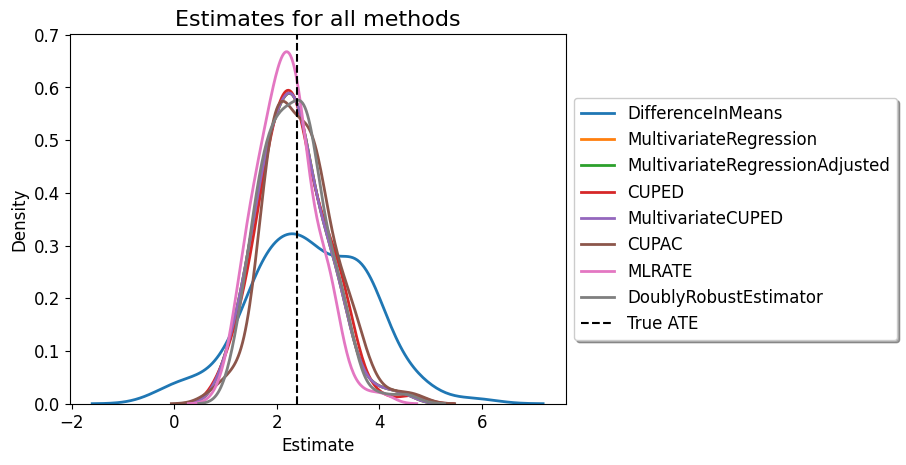

<Axes: title={'center': 'Estimates for all methods'}, xlabel='Estimate', ylabel='Density'>

In [19]:
all_evaluation.plot(plot_what='estimates')

## Evaluation of methods on a grid of parameters

Finally we can compare how all of our methods react to changes in the scope of pre-experiment data used and the models used for training the ML models.

We begin for defining the base method-parameters map, which contains the parameters that will not change:

In [20]:
base_method_params_map = {

    'DifferenceInMeans': {
    },
    
    'CUPED': {
        'covariate_column': 'X1'
    },

    'MultivariateCUPED': {
        'covariate_columns': None
    },

    'MultivariateRegression': {
        'covariate_columns': None
    },

    'MultivariateRegressionAdjusted': {
        'covariate_columns': None
    },

    'CUPAC': {
        'pre_experiment_data': pre_exp_example_data,
        'covariate_columns': None,
        'model': None,
        'model_init_config': None,
        'model_fit_config': None
    },

    'MLRATE': {
        'K_splits': 2,
        'covariate_columns': None,
        'model': None,
        'model_init_config': None,
        'model_fit_config': None
    },

    'DoublyRobustEstimator': {
        'covariate_columns': None,
        'model_regression': None
        
    }

}

To create the parameters grid that we will evaluate over, we use the `generate_parameters_grid` static method of the `VREvaluationGrid`:

In [21]:
parameter_grid = VREvaluationGrid.generate_parameters_grid(
                         base_methods_params_map=base_method_params_map,
                         covariate_columns_list = [['X1'], ['X1', 'X2'], ['X1', 'X2', 'X3']],
                         models = [ElasticNet, LGBMRegressor],
                         model_init_configs = [{}, {}],
                         model_fit_configs = [{}, {}])

Next, we initialize and finally run the evaluation over the grid

In [22]:
all_evaluation_grid = VREvaluationGrid([DifferenceInMeans, MultivariateRegression, MultivariateRegressionAdjusted, CUPED, CUPAC, MLRATE])
all_evaluation_grid = all_evaluation_grid.run(data=example_data, 
                                      treatment_column='T',
                                      target_column='Y',
                                      method_params_grid=parameter_grid,
                                      true_ate=diff_in_means(example_data, 'T', 'Y'))

----- Running evaluation for parameter grid index (0, 0)... -----
Running DifferenceInMeans...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 408.32it/s]


Running MultivariateRegression...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 141.01it/s]


Running MultivariateRegressionAdjusted...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 116.29it/s]


Running CUPED...


 10%|████▏                                     | 10/100 [00:00<00:00, 97.05it/s]

[216.02869847  49.99930072]
[215.77272046  49.10890238]
[215.88551182  49.7199823 ]
[216.17661705  50.13772188]
[216.08717648  49.6898473 ]
[215.81797362  49.55624025]
[215.62761297  49.50864808]
[215.55411044  50.41384675]
[215.51330313  50.02531319]
[216.42232635  49.56609607]
[215.28360468  49.60304702]
[216.05246568  50.03983544]
[216.32285853  50.18426138]
[215.71724067  49.29581419]
[215.53989592  49.43801757]
[215.76170105  49.94185329]
[215.83697966  49.57532442]
[216.16291273  50.19944343]
[214.82475439  49.56647665]
[215.35057522  50.9301318 ]


 40%|████████████████▊                         | 40/100 [00:00<00:00, 98.65it/s]

[215.69314838  50.57738463]
[215.62487143  49.91027529]
[215.61672337  49.84934476]
[215.79274173  49.7931898 ]
[215.6543249   49.90852811]
[215.71607199  49.38864923]
[215.2676469   49.86414933]
[215.2996491  49.9517602]
[215.9501602   49.54756587]
[215.7050417   49.57905084]
[215.27687652  50.01699585]
[215.67640032  49.5654084 ]
[215.63344681  49.49927216]
[215.72857803  49.75382723]
[216.1070665   50.43831419]
[216.16191106  50.55896476]
[215.45088015  49.60849944]
[215.82163348  49.78732892]
[215.94713293  49.2349333 ]
[215.85458623  49.70770494]


 50%|█████████████████████                     | 50/100 [00:00<00:00, 98.76it/s]

[215.62496133  49.61012107]
[215.95324725  49.99258481]
[215.5282364   49.14638345]
[215.23740424  49.5812763 ]
[215.85006131  50.33888888]
[216.0087397   49.88313622]
[215.79130325  49.75515517]
[216.60193247  49.51851281]
[215.65780696  49.67073904]
[215.5216109   49.69739497]
[215.68972268  49.79958122]
[215.77977926  48.9645519 ]
[215.51523863  50.12734889]
[215.78842314  49.60151045]
[215.02835501  49.491813  ]
[215.78357911  49.71372147]
[215.76493694  49.65525696]
[215.44274256  49.67624243]
[215.62356964  50.44831898]
[215.62675492  49.81583019]


 80%|█████████████████████████████████▌        | 80/100 [00:00<00:00, 98.71it/s]

[215.80353313  49.77741224]
[215.11999456  49.85658834]
[215.56960111  50.0149371 ]
[215.30930103  50.04960768]
[215.45995468  49.50777745]
[215.7344489   49.15418293]
[215.7881271   49.72611652]
[215.59521665  49.99618348]
[215.88381449  49.50459117]
[215.30494133  49.41044603]
[216.1772944   49.93807198]
[215.35694092  49.87634447]
[215.6574858   50.20747563]
[215.67980518  49.57499544]
[216.02683607  50.0378283 ]
[215.62779834  49.25375788]
[216.38253167  49.76127068]
[215.34485955  49.36900035]
[216.0855213   49.91108372]
[215.60664946  49.93489722]


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 98.72it/s]


[215.93018221  49.54673098]
[215.82798072  49.16747958]
[215.88670796  49.42811081]
[215.52242471  49.65631636]
[216.12826093  49.85951501]
[215.38563457  49.89071578]
[215.74031584  49.54996764]
[214.88887559  49.39823075]
[215.55184579  49.60344776]
[216.39057696  49.474248  ]
[215.35689525  50.06187276]
[215.72290422  50.18587241]
[215.94900307  49.85284686]
[215.83655648  49.28461883]
[215.69523929  49.79552458]
[215.98776142  49.50982583]
[215.2245362   49.72409936]
[215.48127473  50.06096175]
[215.54179517  49.44371626]
[216.04296149  49.66728424]
Running CUPAC...


  9%|███▊                                       | 9/100 [00:00<00:01, 81.59it/s]

[-111.84246772    1.53056325]
[-106.25964512    1.50330665]
[-110.15402015    1.52201284]
[-112.60224684    1.53480055]
[-109.75474456    1.52109036]
[-109.14781627    1.51700042]
[-109.02609055    1.51554354]
[-115.03544654    1.5432532 ]
[-112.52844048    1.53135954]
[-108.60809339    1.51730212]
[-109.98912112    1.51843325]
[-112.08450605    1.53180408]
[-112.7611895     1.53622521]
[-107.54080245    1.50902834]
[-108.6506473     1.51338142]
[-111.73275185    1.52880468]
[-109.25395439    1.51758461]


 27%|███████████▎                              | 27/100 [00:00<00:00, 80.45it/s]

[-113.02069203    1.53668996]
[-110.20816111    1.51731377]
[-118.62452991    1.55905757]
[-115.96881139    1.54825938]
[-111.66250839    1.52783803]
[-111.27110397    1.52597284]
[-110.7268478     1.52425384]
[-111.62159724    1.52778454]
[-108.15073693    1.51187017]
[-111.71726087    1.52642603]
[-112.25976993    1.52910796]
[-108.95874703    1.51673488]
[-109.41032873    1.51769869]
[-112.71032568    1.53110493]
[-109.3495108     1.51728108]
[-108.95877403    1.51525653]
[-110.53289218    1.52304889]


 45%|██████████████████▉                       | 45/100 [00:00<00:00, 77.93it/s]

[-114.64293737    1.5440022 ]
[-115.37926047    1.54769552]
[-109.85759901    1.51860015]
[-110.65952436    1.52407444]
[-106.91168227    1.50716467]
[-110.10443512    1.52163701]
[-109.69415273    1.5186498 ]
[-111.87387843    1.53035766]
[-106.74991097    1.50445401]
[-109.89256065    1.51776682]
[-114.24795908    1.54095862]
[-111.10067626    1.52700726]
[-110.47887346    1.52308954]
[-108.11645919    1.51584552]
[-110.05881052    1.52050542]
[-110.36980338    1.5213214 ]


 62%|██████████████████████████                | 62/100 [00:00<00:00, 79.13it/s]

[-110.87177835    1.52444949]
[-105.30600569    1.49888784]
[-113.1956048     1.53448302]
[-109.47422679    1.51838622]
[-109.51495056    1.51502818]
[-110.21489738    1.52182119]
[-109.85015601    1.52003149]
[-110.30996325    1.52067389]
[-115.19203987    1.54430846]
[-111.04130217    1.52494692]
[-110.61259643    1.52377087]
[-111.81533229    1.52619458]
[-112.4040998    1.5310419]
[-112.89175323    1.53210323]
[-109.18803924    1.51551689]
[-106.59484528    1.50469277]
[-110.29162918    1.52220062]


 79%|█████████████████████████████████▏        | 79/100 [00:01<00:00, 77.64it/s]

[-112.25550871    1.53046783]
[-108.74328542    1.51541935]
[-108.7048015     1.51253741]
[-111.29236327    1.52868894]
[-111.70793742    1.52679935]
[-113.57879051    1.53693584]
[-109.40897232    1.51757455]
[-112.09697466    1.53174264]
[-107.3544599     1.50774093]
[-109.92774961    1.52327675]
[-108.39310325    1.5112687 ]
[-111.20716049    1.52786278]
[-111.84218946    1.52859175]
[-108.9732509     1.51670932]
[-106.58850569    1.5050998 ]
[-108.23887153    1.51307816]


 97%|████████████████████████████████████████▋ | 97/100 [00:01<00:00, 79.80it/s]

[-110.09961659    1.52006392]
[-110.82625745    1.52628417]
[-111.77348297    1.52723928]
[-109.1843422     1.51680841]
[-109.04076521    1.51216348]
[-109.72350757    1.51844552]
[-108.0375474    1.5144905]
[-112.92458853    1.53247869]
[-113.37170823    1.53627453]
[-110.96178891    1.52608005]
[-107.34807256    1.50868563]
[-110.83965998    1.52432531]
[-108.67366566    1.5155796 ]
[-110.84199288    1.52213887]
[-112.7942336    1.5324508]
[-108.68611729    1.51355587]
[-109.65100305    1.52039967]


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 79.04it/s]


Running MLRATE...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 61.30it/s]


Done!
----- Running evaluation for parameter grid index (0, 1)... -----
Running DifferenceInMeans...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 397.45it/s]


Running MultivariateRegression...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 125.73it/s]


Running MultivariateRegressionAdjusted...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 91.69it/s]


Running CUPED...


  9%|███▊                                       | 9/100 [00:00<00:01, 86.87it/s]

[216.02869847  49.99930072]
[215.77272046  49.10890238]
[215.88551182  49.7199823 ]
[216.17661705  50.13772188]
[216.08717648  49.6898473 ]
[215.81797362  49.55624025]
[215.62761297  49.50864808]
[215.55411044  50.41384675]
[215.51330313  50.02531319]
[216.42232635  49.56609607]
[215.28360468  49.60304702]
[216.05246568  50.03983544]
[216.32285853  50.18426138]
[215.71724067  49.29581419]
[215.53989592  49.43801757]
[215.76170105  49.94185329]
[215.83697966  49.57532442]
[216.16291273  50.19944343]
[214.82475439  49.56647665]


 29%|████████████▏                             | 29/100 [00:00<00:00, 95.49it/s]

[215.35057522  50.9301318 ]
[215.69314838  50.57738463]
[215.62487143  49.91027529]
[215.61672337  49.84934476]
[215.79274173  49.7931898 ]
[215.6543249   49.90852811]
[215.71607199  49.38864923]
[215.2676469   49.86414933]
[215.2996491  49.9517602]
[215.9501602   49.54756587]
[215.7050417   49.57905084]
[215.27687652  50.01699585]
[215.67640032  49.5654084 ]
[215.63344681  49.49927216]
[215.72857803  49.75382723]
[216.1070665   50.43831419]
[216.16191106  50.55896476]
[215.45088015  49.60849944]
[215.82163348  49.78732892]
[215.94713293  49.2349333 ]


 59%|████████████████████████▊                 | 59/100 [00:00<00:00, 97.54it/s]

[215.85458623  49.70770494]
[215.62496133  49.61012107]
[215.95324725  49.99258481]
[215.5282364   49.14638345]
[215.23740424  49.5812763 ]
[215.85006131  50.33888888]
[216.0087397   49.88313622]
[215.79130325  49.75515517]
[216.60193247  49.51851281]
[215.65780696  49.67073904]
[215.5216109   49.69739497]
[215.68972268  49.79958122]
[215.77977926  48.9645519 ]
[215.51523863  50.12734889]
[215.78842314  49.60151045]
[215.02835501  49.491813  ]
[215.78357911  49.71372147]
[215.76493694  49.65525696]
[215.44274256  49.67624243]
[215.62356964  50.44831898]


 69%|████████████████████████████▉             | 69/100 [00:00<00:00, 96.42it/s]

[215.62675492  49.81583019]
[215.80353313  49.77741224]
[215.11999456  49.85658834]
[215.56960111  50.0149371 ]
[215.30930103  50.04960768]
[215.45995468  49.50777745]
[215.7344489   49.15418293]
[215.7881271   49.72611652]
[215.59521665  49.99618348]
[215.88381449  49.50459117]
[215.30494133  49.41044603]
[216.1772944   49.93807198]
[215.35694092  49.87634447]
[215.6574858   50.20747563]
[215.67980518  49.57499544]
[216.02683607  50.0378283 ]
[215.62779834  49.25375788]
[216.38253167  49.76127068]
[215.34485955  49.36900035]


 90%|█████████████████████████████████████▊    | 90/100 [00:00<00:00, 96.00it/s]

[216.0855213   49.91108372]
[215.60664946  49.93489722]
[215.93018221  49.54673098]
[215.82798072  49.16747958]
[215.88670796  49.42811081]
[215.52242471  49.65631636]
[216.12826093  49.85951501]
[215.38563457  49.89071578]
[215.74031584  49.54996764]
[214.88887559  49.39823075]
[215.55184579  49.60344776]
[216.39057696  49.474248  ]
[215.35689525  50.06187276]
[215.72290422  50.18587241]
[215.94900307  49.85284686]
[215.83655648  49.28461883]
[215.69523929  49.79552458]
[215.98776142  49.50982583]
[215.2245362   49.72409936]
[215.48127473  50.06096175]
[215.54179517  49.44371626]


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 95.78it/s]


[216.04296149  49.66728424]
Running CUPAC...


  9%|███▊                                       | 9/100 [00:00<00:01, 81.04it/s]

[-110.73538684    1.52586879]
[-106.47479564    1.50450404]
[-109.51944847    1.51951322]
[-112.06327348    1.53244456]
[-109.27195763    1.51918321]
[-108.83625743    1.51557428]
[-108.75268837    1.51438303]
[-114.75820365    1.54239645]
[-112.43213397    1.5309443 ]
[-108.4953801     1.51722355]
[-109.6778299     1.51751907]
[-112.27410005    1.53309948]
[-112.2886706     1.53405748]
[-107.19128229    1.50755313]
[-108.58199279    1.51378052]
[-111.55913785    1.52817576]
[-108.71284339    1.5155747 ]


 27%|███████████▎                              | 27/100 [00:00<00:00, 81.48it/s]

[-112.18320008    1.53340122]
[-109.70134099    1.5151256 ]
[-117.72684472    1.55524466]
[-115.68758699    1.54745772]
[-111.44850199    1.52730701]
[-111.35407573    1.5266054 ]
[-110.25506365    1.52297449]
[-110.82246644    1.52453436]
[-107.54018003    1.50945765]
[-111.86800122    1.52751231]
[-112.27184529    1.5295333 ]
[-108.44997073    1.51466191]
[-109.04614418    1.51592778]
[-112.54922526    1.53062568]
[-108.97821667    1.51625728]
[-108.02868382    1.51135509]
[-110.06541976    1.52112416]


 45%|██████████████████▉                       | 45/100 [00:00<00:00, 80.69it/s]

[-114.84964187    1.54533051]
[-115.47184489    1.54802036]
[-109.85531178    1.51865695]
[-110.46683998    1.523243  ]
[-106.72559484    1.50672016]
[-110.06222085    1.52196451]
[-109.75444376    1.51930909]
[-111.71831642    1.53007684]
[-106.84758633    1.50490587]
[-109.96928783    1.51807824]
[-113.54210814    1.53790962]
[-110.59210183    1.52448917]
[-110.45818121    1.52341395]
[-107.6975033     1.51395902]
[-109.98065403    1.52071421]
[-109.93017674    1.51973731]
[-109.93791706    1.5203812 ]


 63%|██████████████████████████▍               | 63/100 [00:00<00:00, 79.55it/s]

[-105.24102708    1.49878429]
[-112.59446094    1.53201302]
[-109.11424354    1.51723448]
[-109.31022802    1.51433924]
[-109.51322601    1.51877519]
[-109.89711359    1.52061033]
[-109.80150201    1.51862573]
[-114.48575525    1.54114495]
[-111.04509201    1.52534908]
[-111.08067441    1.52644798]
[-111.87438272    1.52653113]
[-112.24559787    1.53066517]
[-112.35723044    1.52995989]
[-108.58432271    1.51331393]
[-106.78709092    1.50574552]
[-110.01885713    1.52134115]


 80%|█████████████████████████████████▌        | 80/100 [00:00<00:00, 79.44it/s]

[-112.3809062     1.53128976]
[-108.11366242    1.51302778]
[-108.06713872    1.50966612]
[-111.3044231     1.52932444]
[-111.43710418    1.52592902]
[-113.64017616    1.53757827]
[-109.50006444    1.5178634 ]
[-112.34696706    1.53333554]
[-106.77867042    1.50570488]
[-109.17497857    1.51985478]
[-107.95491396    1.51001379]
[-111.30768584    1.52882417]
[-111.07502382    1.52550441]
[-108.22500915    1.51374604]
[-106.6452282     1.50560951]
[-107.82273311    1.51136842]
[-109.49118339    1.51752101]


 97%|████████████████████████████████████████▋ | 97/100 [00:01<00:00, 79.36it/s]

[-110.53142412    1.52490321]
[-111.90672904    1.52840989]
[-108.81278343    1.51550589]
[-108.84673033    1.51142819]
[-109.79083424    1.51919405]
[-108.16599085    1.51519044]
[-112.5691081     1.53084254]
[-113.17291648    1.5358856 ]
[-111.08082435    1.52707767]
[-106.99265251    1.50757029]
[-110.55064137    1.52352887]
[-107.83084436    1.51219367]
[-110.83806651    1.52252343]
[-112.65306036    1.53226301]
[-108.43226979    1.51234772]


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 79.83it/s]


[-109.90711       1.52159594]
Running MLRATE...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 57.97it/s]


Done!
----- Running evaluation for parameter grid index (0, 2)... -----
Running DifferenceInMeans...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 346.82it/s]


Running MultivariateRegression...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 98.13it/s]


Running MultivariateRegressionAdjusted...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 71.65it/s]


Running CUPED...


 11%|████▌                                    | 11/100 [00:00<00:00, 100.27it/s]

[216.02869847  49.99930072]
[215.77272046  49.10890238]
[215.88551182  49.7199823 ]
[216.17661705  50.13772188]
[216.08717648  49.6898473 ]
[215.81797362  49.55624025]
[215.62761297  49.50864808]
[215.55411044  50.41384675]
[215.51330313  50.02531319]
[216.42232635  49.56609607]
[215.28360468  49.60304702]
[216.05246568  50.03983544]
[216.32285853  50.18426138]
[215.71724067  49.29581419]
[215.53989592  49.43801757]
[215.76170105  49.94185329]
[215.83697966  49.57532442]
[216.16291273  50.19944343]
[214.82475439  49.56647665]
[215.35057522  50.9301318 ]
[215.69314838  50.57738463]


 32%|█████████████▍                            | 32/100 [00:00<00:00, 99.51it/s]

[215.62487143  49.91027529]
[215.61672337  49.84934476]
[215.79274173  49.7931898 ]
[215.6543249   49.90852811]
[215.71607199  49.38864923]
[215.2676469   49.86414933]
[215.2996491  49.9517602]
[215.9501602   49.54756587]
[215.7050417   49.57905084]
[215.27687652  50.01699585]
[215.67640032  49.5654084 ]
[215.63344681  49.49927216]
[215.72857803  49.75382723]
[216.1070665   50.43831419]
[216.16191106  50.55896476]
[215.45088015  49.60849944]
[215.82163348  49.78732892]
[215.94713293  49.2349333 ]
[215.85458623  49.70770494]
[215.62496133  49.61012107]


 53%|██████████████████████▎                   | 53/100 [00:00<00:00, 99.37it/s]

[215.95324725  49.99258481]
[215.5282364   49.14638345]
[215.23740424  49.5812763 ]
[215.85006131  50.33888888]
[216.0087397   49.88313622]
[215.79130325  49.75515517]
[216.60193247  49.51851281]
[215.65780696  49.67073904]
[215.5216109   49.69739497]
[215.68972268  49.79958122]
[215.77977926  48.9645519 ]
[215.51523863  50.12734889]
[215.78842314  49.60151045]
[215.02835501  49.491813  ]
[215.78357911  49.71372147]
[215.76493694  49.65525696]
[215.44274256  49.67624243]
[215.62356964  50.44831898]
[215.62675492  49.81583019]
[215.80353313  49.77741224]


 73%|██████████████████████████████▋           | 73/100 [00:00<00:00, 98.81it/s]

[215.11999456  49.85658834]
[215.56960111  50.0149371 ]
[215.30930103  50.04960768]
[215.45995468  49.50777745]
[215.7344489   49.15418293]
[215.7881271   49.72611652]
[215.59521665  49.99618348]
[215.88381449  49.50459117]
[215.30494133  49.41044603]
[216.1772944   49.93807198]
[215.35694092  49.87634447]
[215.6574858   50.20747563]
[215.67980518  49.57499544]
[216.02683607  50.0378283 ]
[215.62779834  49.25375788]
[216.38253167  49.76127068]
[215.34485955  49.36900035]
[216.0855213   49.91108372]
[215.60664946  49.93489722]
[215.93018221  49.54673098]
[215.82798072  49.16747958]

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 98.92it/s]



[215.88670796  49.42811081]
[215.52242471  49.65631636]
[216.12826093  49.85951501]
[215.38563457  49.89071578]
[215.74031584  49.54996764]
[214.88887559  49.39823075]
[215.55184579  49.60344776]
[216.39057696  49.474248  ]
[215.35689525  50.06187276]
[215.72290422  50.18587241]
[215.94900307  49.85284686]
[215.83655648  49.28461883]
[215.69523929  49.79552458]
[215.98776142  49.50982583]
[215.2245362   49.72409936]
[215.48127473  50.06096175]
[215.54179517  49.44371626]
[216.04296149  49.66728424]
Running CUPAC...


  0%|                                                   | 0/100 [00:00<?, ?it/s]

[-113.92093002    1.54065472]


  9%|███▊                                       | 9/100 [00:00<00:01, 81.34it/s]

[-110.99752656    1.52704915]
[-115.26724412    1.54718025]
[-116.15528472    1.55317441]
[-113.21657682    1.53789944]
[-111.81098243    1.52941793]
[-112.9138708     1.53587521]
[-115.92808118    1.54735499]
[-115.63337637    1.54793928]
[-111.3946115     1.53019952]
[-113.99144506    1.53876357]
[-114.57182754    1.54323548]
[-114.34505567    1.54369077]
[-110.92864879    1.52535522]
[-111.6857621     1.52826893]
[-114.12719419    1.53993547]
[-112.72300207    1.53415842]
[-114.58224095    1.54482968]


 27%|███████████▎                              | 27/100 [00:00<00:00, 80.88it/s]

[-114.71196414    1.54138138]
[-117.89600751    1.5571933 ]
[-117.32481182    1.55548895]
[-112.87191561    1.53481959]
[-115.69968904    1.54779548]
[-114.46654269    1.54292428]
[-112.72611696    1.53350265]
[-110.77395915    1.52445988]
[-113.69097456    1.53780734]
[-113.50601164    1.53682418]
[-112.29013056    1.53250483]
[-112.11553841    1.53007609]
[-116.54829401    1.55106115]
[-112.62052396    1.53557759]
[-113.16594919    1.53543481]
[-112.99949399    1.53613646]
[-117.37452182    1.55606202]


 45%|██████████████████▉                       | 45/100 [00:00<00:00, 79.74it/s]

[-116.60224746    1.55274723]
[-114.57129896    1.54036423]
[-113.20944406    1.53706875]
[-110.85934643    1.52753339]
[-113.83425025    1.54133795]
[-113.77329073    1.5391875 ]
[-113.15532046    1.53721926]
[-112.65876658    1.53247603]
[-111.68940618    1.5287518 ]
[-115.6403248    1.5488785]
[-114.92971397    1.5439346 ]
[-112.46533446    1.53283104]
[-113.99496026    1.54282099]
[-112.83805929    1.53516253]
[-114.54042002    1.542421  ]
[-115.75001016    1.54763593]


 63%|██████████████████████████▍               | 63/100 [00:00<00:00, 80.41it/s]

[-111.6841775     1.53060606]
[-112.92778912    1.53446767]
[-111.35426908    1.52836005]
[-113.45422222    1.5372651 ]
[-114.08784561    1.54035644]
[-112.86402596    1.5351478 ]
[-112.89622838    1.53488379]
[-116.08269504    1.54958958]
[-114.27834899    1.54003862]
[-113.00308907    1.53638887]
[-115.82831891    1.54806673]
[-114.3771059     1.54166323]
[-113.35233238    1.53498921]
[-112.44618007    1.53172955]
[-110.66809932    1.52513118]
[-113.58183599    1.53860823]
[-114.88868115    1.54419757]


 81%|██████████████████████████████████        | 81/100 [00:01<00:00, 80.69it/s]

[-111.35390054    1.5278083 ]
[-111.33029967    1.52575009]
[-115.37544874    1.54927602]
[-113.71085859    1.5377702 ]
[-116.13934109    1.54937476]
[-111.55562775    1.52822695]
[-113.7833681     1.54077277]
[-111.41121718    1.52680107]
[-113.22483006    1.53850295]
[-111.58256262    1.52890155]
[-114.12136206    1.54108978]
[-115.50870838    1.54727619]
[-112.70685994    1.53580976]
[-110.40305048    1.52404551]
[-110.79843879    1.52488476]
[-114.67000365    1.54228562]
[-113.04506925    1.53846785]


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 80.64it/s]


[-114.54270612    1.54226584]
[-113.51788266    1.5379031 ]
[-112.66298503    1.5322642 ]
[-112.44566126    1.53301125]
[-112.59966352    1.5363222 ]
[-114.39138535    1.54136834]
[-115.34638311    1.54752526]
[-114.93305042    1.5463057 ]
[-111.93839481    1.53057758]
[-113.27005808    1.53550964]
[-111.39506235    1.52974606]
[-113.21093906    1.53457625]
[-113.56214036    1.53749346]
[-111.00872641    1.5249236 ]
[-111.21722983    1.52825049]
Running MLRATE...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 60.90it/s]


Done!
----- Running evaluation for parameter grid index (1, 0)... -----
Running DifferenceInMeans...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 394.35it/s]


Running MultivariateRegression...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 140.92it/s]


Running MultivariateRegressionAdjusted...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 117.28it/s]


Running CUPED...


 10%|████▏                                     | 10/100 [00:00<00:00, 99.18it/s]

[216.02869847  49.99930072]
[215.77272046  49.10890238]
[215.88551182  49.7199823 ]
[216.17661705  50.13772188]
[216.08717648  49.6898473 ]
[215.81797362  49.55624025]
[215.62761297  49.50864808]
[215.55411044  50.41384675]
[215.51330313  50.02531319]
[216.42232635  49.56609607]
[215.28360468  49.60304702]
[216.05246568  50.03983544]
[216.32285853  50.18426138]
[215.71724067  49.29581419]
[215.53989592  49.43801757]
[215.76170105  49.94185329]
[215.83697966  49.57532442]
[216.16291273  50.19944343]
[214.82475439  49.56647665]
[215.35057522  50.9301318 ]


 30%|████████████▌                             | 30/100 [00:00<00:00, 97.47it/s]

[215.69314838  50.57738463]
[215.62487143  49.91027529]
[215.61672337  49.84934476]
[215.79274173  49.7931898 ]
[215.6543249   49.90852811]
[215.71607199  49.38864923]
[215.2676469   49.86414933]
[215.2996491  49.9517602]
[215.9501602   49.54756587]
[215.7050417   49.57905084]
[215.27687652  50.01699585]
[215.67640032  49.5654084 ]
[215.63344681  49.49927216]
[215.72857803  49.75382723]
[216.1070665   50.43831419]
[216.16191106  50.55896476]
[215.45088015  49.60849944]
[215.82163348  49.78732892]
[215.94713293  49.2349333 ]
[215.85458623  49.70770494]


 50%|█████████████████████                     | 50/100 [00:00<00:00, 98.54it/s]

[215.62496133  49.61012107]
[215.95324725  49.99258481]
[215.5282364   49.14638345]
[215.23740424  49.5812763 ]
[215.85006131  50.33888888]
[216.0087397   49.88313622]
[215.79130325  49.75515517]
[216.60193247  49.51851281]
[215.65780696  49.67073904]
[215.5216109   49.69739497]
[215.68972268  49.79958122]
[215.77977926  48.9645519 ]
[215.51523863  50.12734889]
[215.78842314  49.60151045]
[215.02835501  49.491813  ]
[215.78357911  49.71372147]
[215.76493694  49.65525696]
[215.44274256  49.67624243]
[215.62356964  50.44831898]
[215.62675492  49.81583019]


 80%|█████████████████████████████████▌        | 80/100 [00:00<00:00, 98.41it/s]

[215.80353313  49.77741224]
[215.11999456  49.85658834]
[215.56960111  50.0149371 ]
[215.30930103  50.04960768]
[215.45995468  49.50777745]
[215.7344489   49.15418293]
[215.7881271   49.72611652]
[215.59521665  49.99618348]
[215.88381449  49.50459117]
[215.30494133  49.41044603]
[216.1772944   49.93807198]
[215.35694092  49.87634447]
[215.6574858   50.20747563]
[215.67980518  49.57499544]
[216.02683607  50.0378283 ]
[215.62779834  49.25375788]
[216.38253167  49.76127068]
[215.34485955  49.36900035]
[216.0855213   49.91108372]
[215.60664946  49.93489722]


 91%|██████████████████████████████████████▏   | 91/100 [00:00<00:00, 99.08it/s]

[215.93018221  49.54673098]
[215.82798072  49.16747958]
[215.88670796  49.42811081]
[215.52242471  49.65631636]
[216.12826093  49.85951501]
[215.38563457  49.89071578]
[215.74031584  49.54996764]
[214.88887559  49.39823075]
[215.55184579  49.60344776]
[216.39057696  49.474248  ]
[215.35689525  50.06187276]
[215.72290422  50.18587241]
[215.94900307  49.85284686]
[215.83655648  49.28461883]
[215.69523929  49.79552458]
[215.98776142  49.50982583]
[215.2245362   49.72409936]
[215.48127473  50.06096175]
[215.54179517  49.44371626]
[216.04296149  49.66728424]


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 98.14it/s]


Running CUPAC...


  2%|▊                                          | 2/100 [00:00<00:06, 15.26it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[2.86751105 0.99282668]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[5.72399002 0.97809052]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of u

  6%|██▌                                        | 6/100 [00:00<00:06, 15.10it/s]

[2.23587314 0.99600236]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[3.51792407 0.99002703]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[3.92727759 0.98729682]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the trai

  8%|███▍                                       | 8/100 [00:00<00:06, 14.98it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[-0.36539678  1.00534084]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[0.80243247 0.99966266]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of

 12%|█████                                     | 12/100 [00:00<00:05, 14.77it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[3.11169252 0.98841659]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[2.98684116 0.99220889]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of u

 14%|█████▉                                    | 14/100 [00:00<00:05, 14.89it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[4.84955748 0.9817216 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[3.95550512 0.98523019]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of u

 18%|███████▌                                  | 18/100 [00:01<00:05, 14.53it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[3.84708103 0.98692599]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[1.23266472 1.0009526 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of u

 20%|████████▍                                 | 20/100 [00:01<00:05, 14.70it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[-1.76557189  1.01108074]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[-0.30138184  1.00622032]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number 

 22%|█████████▏                                | 22/100 [00:01<00:05, 14.86it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313


 24%|██████████                                | 24/100 [00:01<00:05, 14.46it/s]

[2.87251714 0.99066236]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[2.77541489 0.99176212]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[2.35249401 0.99315749]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the trai

 26%|██████████▉                               | 26/100 [00:01<00:05, 14.57it/s]

[4.50953535 0.98287032]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[2.11736851 0.99308248]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313


 28%|███████████▊                              | 28/100 [00:01<00:04, 14.55it/s]

[2.66611168 0.98989454]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313


 30%|████████████▌                             | 30/100 [00:02<00:05, 13.37it/s]

[3.50036671 0.98859564]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[4.23097569 0.98490652]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[1.50465628 0.99564038]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the trai

 32%|█████████████▍                            | 32/100 [00:02<00:05, 13.60it/s]

[4.22081859 0.98438768]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[5.08768087 0.98034414]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[3.83408254 0.98685201]


 34%|██████████████▎                           | 34/100 [00:02<00:04, 14.00it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313


 36%|███████████████                           | 36/100 [00:02<00:04, 14.24it/s]

[1.3313777  0.99996343]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[0.61507348 1.00396279]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[4.22843647 0.98348555]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] To

 38%|███████████████▉                          | 38/100 [00:02<00:04, 14.21it/s]

[2.70081167 0.99221988]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[5.41789813 0.98079047]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[3.27735972 0.98950394]


 40%|████████████████▊                         | 40/100 [00:02<00:04, 14.36it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313


 42%|█████████████████▋                        | 42/100 [00:02<00:03, 14.59it/s]

[3.83622279 0.98612569]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[2.45009684 0.99403777]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[5.72685973 0.97679159]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the trai

 46%|███████████████████▎                      | 46/100 [00:03<00:03, 14.60it/s]

[4.02878825 0.98342041]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[0.62929498 1.00189984]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[3.15609633 0.99132168]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the trai

 48%|████████████████████▏                     | 48/100 [00:03<00:03, 14.79it/s]

[3.05984115 0.98978666]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[4.8184471 0.9860224]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[3.51934148 0.987248  ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train 

 52%|█████████████████████▊                    | 52/100 [00:03<00:03, 14.97it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[2.9675209  0.99046375]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[6.73817483 0.97344001]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of u

 56%|███████████████████████▌                  | 56/100 [00:03<00:02, 14.77it/s]

[4.94044796 0.98188147]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[3.87607621 0.98341961]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[3.96373246 0.98623009]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the trai

 58%|████████████████████████▎                 | 58/100 [00:03<00:02, 14.65it/s]

[4.58891126 0.98360915]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[3.38277941 0.98751319]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[0.67353858 1.00040256]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the trai

 62%|██████████████████████████                | 62/100 [00:04<00:02, 15.04it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[3.33927896 0.98908208]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[2.32734292 0.99060093]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of u

 66%|███████████████████████████▋              | 66/100 [00:04<00:02, 14.91it/s]

[1.78354325 0.99422682]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[3.47562046 0.98695529]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[6.05206564 0.97656924]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the trai

 68%|████████████████████████████▌             | 68/100 [00:04<00:02, 14.83it/s]

[3.84323504 0.98686929]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[1.65290038 0.99652952]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[3.91651116 0.98713979]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the trai

 72%|██████████████████████████████▏           | 72/100 [00:04<00:01, 14.81it/s]

[4.85992291 0.9801307 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[2.56105761 0.99510373]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[2.74549661 0.99033146]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the trai

 74%|███████████████████████████████           | 74/100 [00:05<00:01, 14.83it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[3.70874187 0.98741254]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[2.66247214 0.99328115]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of u

 78%|████████████████████████████████▊         | 78/100 [00:05<00:01, 14.70it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[3.35190879 0.99231632]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[5.09020038 0.97920354]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of u

 80%|█████████████████████████████████▌        | 80/100 [00:05<00:01, 14.30it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[2.69579322 0.99128703]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[4.84248526 0.98286846]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of u

 84%|███████████████████████████████████▎      | 84/100 [00:05<00:01, 14.64it/s]

[5.28551218 0.98036841]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[4.99041101 0.9821175 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[3.77106942 0.98602537]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the trai

 86%|████████████████████████████████████      | 86/100 [00:05<00:01, 13.87it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[2.21443177 0.99271716]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[4.43987418 0.98397859]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of u

 88%|████████████████████████████████████▉     | 88/100 [00:06<00:01,  7.76it/s]

[3.16818236 0.9859203 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[4.10913299 0.98384412]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313


 91%|██████████████████████████████████████▏   | 91/100 [00:07<00:01,  5.78it/s]

[5.10396814 0.98408242]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[1.20281058 0.99699013]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313


 93%|███████████████████████████████████████   | 93/100 [00:07<00:00,  7.15it/s]

[1.87378825 0.99611016]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[3.46341804 0.98944653]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[4.62348622 0.98303108]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the trai

 97%|████████████████████████████████████████▋ | 97/100 [00:07<00:00,  9.81it/s]

[2.40521893 0.99282163]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[5.57546467 0.9792363 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[2.80409067 0.98869956]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the trai

100%|█████████████████████████████████████████| 100/100 [00:07<00:00, 12.83it/s]


[1.86138099 0.99440532]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[4.80905197 0.98091256]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 1
[LightGBM] [Info] Start training from score 213.407313
[3.98699655 0.98672362]
Running MLRATE...


  0%|                                                   | 0/100 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.244701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.616262


  1%|▍                                          | 1/100 [00:00<00:13,  7.09it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.247413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.877739


  2%|▊                                          | 2/100 [00:00<00:13,  7.15it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 216.066388
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 216.192518


  3%|█▎                                         | 3/100 [00:00<00:13,  7.31it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 216.769874
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.277861


  4%|█▋                                         | 4/100 [00:00<00:13,  7.10it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.848729
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 213.896353


  5%|██▏                                        | 5/100 [00:00<00:13,  7.17it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.953858
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.844462


  6%|██▌                                        | 6/100 [00:00<00:12,  7.24it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.792288
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.074056


  7%|███                                        | 7/100 [00:01<00:14,  6.22it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.453938
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.116754


  8%|███▍                                       | 8/100 [00:01<00:13,  6.67it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.400795
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.920830


  9%|███▊                                       | 9/100 [00:01<00:13,  6.87it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 216.196290
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 216.428382


 10%|████▏                                     | 10/100 [00:01<00:12,  7.03it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.540381
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 213.807465


 11%|████▌                                     | 11/100 [00:01<00:12,  7.10it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.215786
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 216.421960


 12%|█████                                     | 12/100 [00:01<00:12,  7.19it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.900950
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 216.198398


 13%|█████▍                                    | 13/100 [00:01<00:11,  7.34it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.415573
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 216.004386


 14%|█████▉                                    | 14/100 [00:01<00:11,  7.18it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.272185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.503758


 15%|██████▎                                   | 15/100 [00:02<00:11,  7.26it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 216.525548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.805470


 16%|██████▋                                   | 16/100 [00:02<00:11,  7.21it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.032645
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.982290


 17%|███████▏                                  | 17/100 [00:02<00:11,  7.17it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 216.242460
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 216.619489


 18%|███████▌                                  | 18/100 [00:02<00:11,  7.21it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 212.938548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.622233


 19%|███████▉                                  | 19/100 [00:02<00:11,  7.31it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.586664
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.866758


 20%|████████▍                                 | 20/100 [00:02<00:10,  7.34it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.723128
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.332895


 21%|████████▊                                 | 21/100 [00:02<00:10,  7.29it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 213.456370
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 216.035646


 22%|█████████▏                                | 22/100 [00:03<00:10,  7.31it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.473897
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.698463


 23%|█████████▋                                | 23/100 [00:03<00:10,  7.40it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.627181
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.814062


 24%|██████████                                | 24/100 [00:03<00:10,  7.26it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.768020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.018075


 25%|██████████▌                               | 25/100 [00:03<00:10,  7.26it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.305331
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.312802


 26%|██████████▉                               | 26/100 [00:03<00:09,  7.42it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.845923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.858964


 27%|███████████▎                              | 27/100 [00:03<00:09,  7.45it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.143512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.114619


 28%|███████████▊                              | 28/100 [00:03<00:09,  7.49it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.841084
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.909448


 29%|████████████▏                             | 29/100 [00:04<00:09,  7.44it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.518195
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.438194


 30%|████████████▌                             | 30/100 [00:04<00:09,  7.22it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.171450


 31%|█████████████                             | 31/100 [00:04<00:10,  6.51it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.208326
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.254127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training

 32%|█████████████▍                            | 32/100 [00:04<00:09,  6.83it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 213.699447
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 216.878004


 33%|█████████████▊                            | 33/100 [00:04<00:09,  6.97it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.058805
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 216.578435


 34%|██████████████▎                           | 34/100 [00:04<00:09,  7.16it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 216.487510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.327434


 35%|██████████████▋                           | 35/100 [00:04<00:09,  7.18it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 216.042411
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 216.250936


 36%|███████████████                           | 36/100 [00:05<00:08,  7.19it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.885121
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.997123


 37%|███████████████▌                          | 37/100 [00:05<00:08,  7.26it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.563203
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.538816


 38%|███████████████▉                          | 38/100 [00:05<00:08,  7.28it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.427839
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.536342


 39%|████████████████▍                         | 39/100 [00:05<00:08,  7.24it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.191167
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.616036


 40%|████████████████▊                         | 40/100 [00:05<00:08,  7.21it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.784078
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.682475


 41%|█████████████████▏                        | 41/100 [00:05<00:08,  7.35it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.428360
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.716067


 42%|█████████████████▋                        | 42/100 [00:05<00:07,  7.38it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.502680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.911379


 43%|██████████████████                        | 43/100 [00:05<00:07,  7.38it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.347680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 213.642707


 44%|██████████████████▍                       | 44/100 [00:06<00:07,  7.45it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.923159
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 216.307764


 45%|██████████████████▉                       | 45/100 [00:06<00:07,  7.39it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.526367
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.539840


 46%|███████████████████▎                      | 46/100 [00:06<00:07,  7.44it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.199808
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.035716


 47%|███████████████████▋                      | 47/100 [00:06<00:07,  7.27it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 216.330513
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.519173


 48%|████████████████████▏                     | 48/100 [00:06<00:07,  7.35it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.320760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.053144


 49%|████████████████████▌                     | 49/100 [00:06<00:06,  7.45it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.465832
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.907711


 50%|█████████████████████                     | 50/100 [00:06<00:06,  7.52it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 216.340901
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 216.278010


 51%|█████████████████████▍                    | 51/100 [00:07<00:06,  7.47it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 217.044811
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.601200


 52%|█████████████████████▊                    | 52/100 [00:07<00:06,  6.95it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.736398


 53%|██████████████████████▎                   | 53/100 [00:07<00:06,  7.07it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.228160
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.774969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training

 55%|███████████████████████                   | 55/100 [00:07<00:06,  7.30it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.390876
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.631045
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training

 57%|███████████████████████▉                  | 57/100 [00:07<00:05,  7.40it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.599570
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.916602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training

 59%|████████████████████████▊                 | 59/100 [00:08<00:05,  7.48it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 217.169802
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 213.764815
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training

 61%|█████████████████████████▌                | 61/100 [00:08<00:05,  7.46it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.699395
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.286654
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training

 63%|██████████████████████████▍               | 63/100 [00:08<00:04,  7.43it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.153970
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.434272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training

 65%|███████████████████████████▎              | 65/100 [00:08<00:04,  7.29it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.638170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.180985
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training

 67%|████████████████████████████▏             | 67/100 [00:09<00:04,  7.28it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 216.446230
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.653443
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training

 69%|████████████████████████████▉             | 69/100 [00:09<00:04,  7.35it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.035131
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 216.488627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training

 71%|█████████████████████████████▊            | 71/100 [00:09<00:03,  7.36it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 216.328521
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 213.777114
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training

 73%|██████████████████████████████▋           | 73/100 [00:10<00:03,  7.31it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 216.082450
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.843004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training

 74%|███████████████████████████████           | 74/100 [00:10<00:04,  5.31it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 216.153552
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.089807
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training

 76%|███████████████████████████████▉          | 76/100 [00:10<00:03,  6.34it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 213.157698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.178620
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training

 78%|████████████████████████████████▊         | 78/100 [00:10<00:03,  6.94it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 213.907219
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.277184
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training

 79%|█████████████████████████████████▏        | 79/100 [00:11<00:02,  7.01it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.628210
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.097015


 81%|██████████████████████████████████        | 81/100 [00:11<00:02,  6.50it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.818299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.001188
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training

 83%|██████████████████████████████████▊       | 83/100 [00:11<00:02,  6.91it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.418790
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 217.119569
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training

 85%|███████████████████████████████████▋      | 85/100 [00:11<00:02,  7.27it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.934528
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.500001
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training

 87%|████████████████████████████████████▌     | 87/100 [00:12<00:01,  7.36it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.355905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.876345
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training

 89%|█████████████████████████████████████▍    | 89/100 [00:12<00:01,  7.45it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.634297
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.192411
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training

 91%|██████████████████████████████████████▏   | 91/100 [00:12<00:01,  7.55it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 213.981617
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.336069
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training

 93%|███████████████████████████████████████   | 93/100 [00:12<00:00,  7.35it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.679259
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.505329
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training

 95%|███████████████████████████████████████▉  | 95/100 [00:13<00:00,  7.30it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 213.917189
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 216.308415
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training

 97%|████████████████████████████████████████▋ | 97/100 [00:13<00:00,  7.32it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 213.861449
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.907642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training

 99%|█████████████████████████████████████████▌| 99/100 [00:13<00:00,  7.34it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 214.610928
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training from score 215.875594
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 1
[LightGBM] [Info] Start training

100%|█████████████████████████████████████████| 100/100 [00:13<00:00,  7.17it/s]


Done!
----- Running evaluation for parameter grid index (1, 1)... -----
Running DifferenceInMeans...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 400.54it/s]


Running MultivariateRegression...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 115.72it/s]


Running MultivariateRegressionAdjusted...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 90.86it/s]


Running CUPED...


 10%|████▏                                     | 10/100 [00:00<00:00, 98.23it/s]

[216.02869847  49.99930072]
[215.77272046  49.10890238]
[215.88551182  49.7199823 ]
[216.17661705  50.13772188]
[216.08717648  49.6898473 ]
[215.81797362  49.55624025]
[215.62761297  49.50864808]
[215.55411044  50.41384675]
[215.51330313  50.02531319]
[216.42232635  49.56609607]
[215.28360468  49.60304702]
[216.05246568  50.03983544]
[216.32285853  50.18426138]
[215.71724067  49.29581419]
[215.53989592  49.43801757]
[215.76170105  49.94185329]
[215.83697966  49.57532442]
[216.16291273  50.19944343]
[214.82475439  49.56647665]
[215.35057522  50.9301318 ]


 31%|█████████████                             | 31/100 [00:00<00:00, 98.88it/s]

[215.69314838  50.57738463]
[215.62487143  49.91027529]
[215.61672337  49.84934476]
[215.79274173  49.7931898 ]
[215.6543249   49.90852811]
[215.71607199  49.38864923]
[215.2676469   49.86414933]
[215.2996491  49.9517602]
[215.9501602   49.54756587]
[215.7050417   49.57905084]
[215.27687652  50.01699585]
[215.67640032  49.5654084 ]
[215.63344681  49.49927216]
[215.72857803  49.75382723]
[216.1070665   50.43831419]
[216.16191106  50.55896476]
[215.45088015  49.60849944]
[215.82163348  49.78732892]
[215.94713293  49.2349333 ]
[215.85458623  49.70770494]


 52%|█████████████████████▊                    | 52/100 [00:00<00:00, 99.34it/s]

[215.62496133  49.61012107]
[215.95324725  49.99258481]
[215.5282364   49.14638345]
[215.23740424  49.5812763 ]
[215.85006131  50.33888888]
[216.0087397   49.88313622]
[215.79130325  49.75515517]
[216.60193247  49.51851281]
[215.65780696  49.67073904]
[215.5216109   49.69739497]
[215.68972268  49.79958122]
[215.77977926  48.9645519 ]
[215.51523863  50.12734889]
[215.78842314  49.60151045]
[215.02835501  49.491813  ]
[215.78357911  49.71372147]
[215.76493694  49.65525696]
[215.44274256  49.67624243]
[215.62356964  50.44831898]
[215.62675492  49.81583019]
[215.80353313  49.77741224]


 72%|██████████████████████████████▏           | 72/100 [00:00<00:00, 99.55it/s]

[215.11999456  49.85658834]
[215.56960111  50.0149371 ]
[215.30930103  50.04960768]
[215.45995468  49.50777745]
[215.7344489   49.15418293]
[215.7881271   49.72611652]
[215.59521665  49.99618348]
[215.88381449  49.50459117]
[215.30494133  49.41044603]
[216.1772944   49.93807198]
[215.35694092  49.87634447]
[215.6574858   50.20747563]
[215.67980518  49.57499544]
[216.02683607  50.0378283 ]
[215.62779834  49.25375788]
[216.38253167  49.76127068]
[215.34485955  49.36900035]
[216.0855213   49.91108372]
[215.60664946  49.93489722]
[215.93018221  49.54673098]


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 98.64it/s]


[215.82798072  49.16747958]
[215.88670796  49.42811081]
[215.52242471  49.65631636]
[216.12826093  49.85951501]
[215.38563457  49.89071578]
[215.74031584  49.54996764]
[214.88887559  49.39823075]
[215.55184579  49.60344776]
[216.39057696  49.474248  ]
[215.35689525  50.06187276]
[215.72290422  50.18587241]
[215.94900307  49.85284686]
[215.83655648  49.28461883]
[215.69523929  49.79552458]
[215.98776142  49.50982583]
[215.2245362   49.72409936]
[215.48127473  50.06096175]
[215.54179517  49.44371626]
[216.04296149  49.66728424]
Running CUPAC...


  0%|                                                   | 0/100 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


  2%|▊                                          | 2/100 [00:00<00:07, 13.50it/s]

[6.51454561 0.97647818]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[9.04890355 0.96352222]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[7.66938799 0.97020544]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

  4%|█▋                                         | 4/100 [00:00<00:06, 14.20it/s]

[5.90014094 0.97940401]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[7.78820353 0.97136221]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


  6%|██▌                                        | 6/100 [00:00<00:06, 14.15it/s]

[7.54888882 0.97009359]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


  8%|███▍                                       | 8/100 [00:00<00:06, 14.36it/s]

[7.45764415 0.96982124]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[3.41595587 0.98903241]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[4.19160271 0.98431811]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the trai

 10%|████▏                                     | 10/100 [00:00<00:06, 14.56it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[6.43144306 0.97368928]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


 12%|█████                                     | 12/100 [00:00<00:06, 14.25it/s]

[5.72218437 0.98053956]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


 14%|█████▉                                    | 14/100 [00:00<00:06, 14.16it/s]

[5.08606447 0.98461555]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[8.89618926 0.96332907]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[7.22664715 0.97179109]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the trai

 16%|██████▋                                   | 16/100 [00:01<00:06, 13.96it/s]

[6.0264941  0.97782153]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[7.95407963 0.96827271]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


 18%|███████▌                                  | 18/100 [00:01<00:05, 13.87it/s]

[5.06029265 0.98418068]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


 20%|████████▍                                 | 20/100 [00:01<00:05, 13.80it/s]

[7.35969658 0.96731564]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[2.4567753  0.99180654]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[3.16631751 0.99077552]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `f

 22%|█████████▏                                | 22/100 [00:01<00:05, 13.83it/s]

[5.96926916 0.97662244]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[6.4686762  0.97473929]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


 24%|██████████                                | 24/100 [00:01<00:05, 13.93it/s]

[6.99049078 0.97413477]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


 26%|██████████▉                               | 26/100 [00:01<00:05, 14.03it/s]

[6.70895222 0.97441049]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[8.72283555 0.96453984]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[5.91728256 0.97619611]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

 28%|███████████▊                              | 28/100 [00:02<00:05, 13.71it/s]

[5.95760222 0.97591108]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[7.38147013 0.97130635]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


 30%|████████████▌                             | 30/100 [00:02<00:05, 13.67it/s]

[7.37581731 0.97077455]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


 32%|█████████████▍                            | 32/100 [00:02<00:04, 13.76it/s]

[4.57553404 0.98297798]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[8.32208361 0.96656373]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[8.55236959 0.96600112]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

 34%|██████████████▎                           | 34/100 [00:02<00:04, 13.88it/s]

[7.76751411 0.96905675]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[4.20562561 0.98713936]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


 36%|███████████████                           | 36/100 [00:02<00:04, 13.89it/s]

[3.64139914 0.99048589]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


 38%|███████████████▉                          | 38/100 [00:02<00:04, 13.95it/s]

[7.56549475 0.96850159]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[6.64560518 0.97419808]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[8.99046559 0.96465634]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `f

 40%|████████████████▊                         | 40/100 [00:02<00:04, 13.82it/s]

[6.95289207 0.97379712]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[6.97318003 0.97241969]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


 42%|█████████████████▋                        | 42/100 [00:03<00:04, 13.78it/s]

[5.57614932 0.98066359]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


 44%|██████████████████▍                       | 44/100 [00:03<00:04, 13.72it/s]

[8.47818262 0.96524413]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[7.1600175  0.96865569]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[5.64425475 0.97963357]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `f

 46%|███████████████████▎                      | 46/100 [00:03<00:03, 13.58it/s]

[6.7494526  0.97454347]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[6.02219327 0.97746905]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


 48%|████████████████████▏                     | 48/100 [00:03<00:03, 13.77it/s]

[8.39844945 0.96928961]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


 50%|█████████████████████                     | 50/100 [00:03<00:03, 14.04it/s]

[7.02223893 0.97207395]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[7.12895366 0.9721287 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[7.00260472 0.97241145]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

 52%|█████████████████████▊                    | 52/100 [00:03<00:03, 14.02it/s]

[9.41680069 0.96235521]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[4.62110447 0.98316853]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


 54%|██████████████████████▋                   | 54/100 [00:03<00:03, 13.87it/s]

[8.17720797 0.96826476]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


 56%|███████████████████████▌                  | 56/100 [00:04<00:03, 14.07it/s]

[7.33243916 0.96778875]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[7.37581478 0.97131983]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[7.21288762 0.97209436]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

 58%|████████████████████████▎                 | 58/100 [00:04<00:02, 14.04it/s]

[7.02192045 0.97131638]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[4.53287719 0.98304059]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


 60%|█████████████████████████▏                | 60/100 [00:04<00:02, 14.06it/s]

[5.41213436 0.97990767]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


 62%|██████████████████████████                | 62/100 [00:04<00:02, 14.12it/s]

[5.92212435 0.97765085]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[5.11308415 0.97787151]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[6.10667613 0.97598765]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

 64%|██████████████████████████▉               | 64/100 [00:04<00:02, 13.94it/s]

[6.11884098 0.97477045]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[6.73015041 0.97260701]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


 66%|███████████████████████████▋              | 66/100 [00:04<00:02, 13.84it/s]

[9.00602103 0.96407035]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


 68%|████████████████████████████▌             | 68/100 [00:04<00:02, 14.05it/s]

[7.2600192  0.97208808]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[4.40527865 0.98453886]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[7.62008985 0.97082529]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

 70%|█████████████████████████████▍            | 70/100 [00:05<00:02, 13.74it/s]

[8.42107433 0.96358537]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[6.73805688 0.97638486]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


 72%|██████████████████████████████▏           | 72/100 [00:05<00:02, 13.85it/s]

[6.22671321 0.97464472]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


 74%|███████████████████████████████           | 74/100 [00:05<00:01, 14.00it/s]

[4.9469918  0.98255121]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[7.08106371 0.97150245]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[4.97384043 0.98316621]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

 76%|███████████████████████████████▉          | 76/100 [00:05<00:01, 14.01it/s]

[8.18718952 0.96578577]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[6.90132336 0.97602391]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


 78%|████████████████████████████████▊         | 78/100 [00:05<00:01, 13.97it/s]

[8.65553183 0.96447425]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


 80%|█████████████████████████████████▌        | 80/100 [00:05<00:01, 14.05it/s]

[6.64044547 0.97637151]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[6.18064062 0.97567912]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[8.77983975 0.96551819]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

 82%|██████████████████████████████████▍       | 82/100 [00:05<00:01, 14.10it/s]

[8.38202488 0.966625  ]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[9.24584667 0.96275116]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


 84%|███████████████████████████████████▎      | 84/100 [00:06<00:01, 14.03it/s]

[7.2429558  0.97102514]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


 86%|████████████████████████████████████      | 86/100 [00:06<00:01, 13.87it/s]

[6.72747293 0.97456557]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[5.8213807  0.97621043]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[7.89944558 0.96866187]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

 88%|████████████████████████████████████▉     | 88/100 [00:06<00:00, 14.04it/s]

[6.24835606 0.97231934]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[7.86022019 0.96742205]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


 90%|█████████████████████████████████████▊    | 90/100 [00:06<00:00, 13.85it/s]

[8.11212621 0.97028272]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


 92%|██████████████████████████████████████▋   | 92/100 [00:06<00:00, 13.96it/s]

[4.8393469  0.98063332]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[5.63072589 0.97935043]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[6.18106322 0.97756535]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

 94%|███████████████████████████████████████▍  | 94/100 [00:06<00:00, 14.08it/s]

[7.82369888 0.96918246]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[6.19735759 0.97685229]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


 96%|████████████████████████████████████████▎ | 96/100 [00:06<00:00, 13.77it/s]

[9.05057716 0.96426333]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313


 98%|█████████████████████████████████████████▏| 98/100 [00:07<00:00, 13.72it/s]

[5.76023559 0.97595217]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[4.77336937 0.98217286]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 2
[LightGBM] [Info] Start training from score 213.407313
[8.03303083 0.96672655]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

100%|█████████████████████████████████████████| 100/100 [00:07<00:00, 13.85it/s]


[7.00684893 0.97311083]
Running MLRATE...


  0%|                                                   | 0/100 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.494205
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.366758


  1%|▍                                          | 1/100 [00:00<00:13,  7.15it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.672864
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.452288


  2%|▊                                          | 2/100 [00:00<00:13,  7.34it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 216.269420
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.989487


  3%|█▎                                         | 3/100 [00:00<00:13,  7.26it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 216.288810
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.758925


  4%|█▋                                         | 4/100 [00:00<00:13,  7.15it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.252283
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.492798


  5%|██▏                                        | 5/100 [00:00<00:13,  7.00it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.385017


  6%|██▌                                        | 6/100 [00:00<00:13,  6.99it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.413303
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.166392
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins

  8%|███▍                                       | 8/100 [00:01<00:12,  7.22it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.666208
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.904484
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5

 10%|████▏                                     | 10/100 [00:01<00:12,  7.23it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.930437
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 216.694235
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

 12%|█████                                     | 12/100 [00:01<00:11,  7.38it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.190301
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 216.447446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5

 14%|█████▉                                    | 14/100 [00:01<00:11,  7.33it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.506885
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.913074
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

 16%|██████▋                                   | 16/100 [00:02<00:11,  7.19it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 216.363040
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.967978
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

 18%|███████▌                                  | 18/100 [00:02<00:11,  7.19it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 216.521471
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 216.340479
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

 20%|████████▍                                 | 20/100 [00:02<00:11,  7.20it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.900106
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.553316
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training

 22%|█████████▏                                | 22/100 [00:03<00:10,  7.10it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.637301
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 213.854714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5

 24%|██████████                                | 24/100 [00:03<00:10,  7.12it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.439979
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.001265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

 26%|██████████▉                               | 26/100 [00:03<00:10,  7.18it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.287647
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.330487
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5

 28%|███████████▊                              | 28/100 [00:03<00:10,  7.15it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.324791
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 213.933340
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins

 30%|████████████▌                             | 30/100 [00:04<00:09,  7.12it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.103702
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.852687
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins

 32%|█████████████▍                            | 32/100 [00:04<00:09,  7.20it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.375980
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.790373
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5

 34%|██████████████▎                           | 34/100 [00:04<00:09,  7.11it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.349236
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 216.288004
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5

 36%|███████████████                           | 36/100 [00:05<00:08,  7.15it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 216.777950
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.515397
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training

 38%|███████████████▉                          | 38/100 [00:05<00:08,  7.21it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.785170
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.316848
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins

 40%|████████████████▊                         | 40/100 [00:05<00:08,  7.20it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.087118
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.720086
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

 41%|█████████████████▏                        | 41/100 [00:05<00:11,  5.07it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.721557
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.422869


 42%|█████████████████▋                        | 42/100 [00:06<00:17,  3.31it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.623649


 43%|██████████████████                        | 43/100 [00:06<00:20,  2.85it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.790410
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 213.964651


 44%|██████████████████▍                       | 44/100 [00:07<00:16,  3.44it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.025736
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.956161
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

 46%|███████████████████▎                      | 46/100 [00:07<00:11,  4.75it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.522164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.544043
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training

 48%|████████████████████▏                     | 48/100 [00:07<00:08,  5.78it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 216.065354
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.784332
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

 50%|█████████████████████                     | 50/100 [00:07<00:07,  6.46it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 216.713629
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.659914
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

 52%|█████████████████████▊                    | 52/100 [00:08<00:06,  6.88it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.904288
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 216.741724
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training

 54%|██████████████████████▋                   | 54/100 [00:08<00:06,  6.99it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.284543
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 216.440131
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training

 56%|███████████████████████▌                  | 56/100 [00:08<00:06,  7.11it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.351888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.485104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

 58%|████████████████████████▎                 | 58/100 [00:09<00:05,  7.04it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.121429
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.982456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins

 59%|████████████████████████▊                 | 59/100 [00:09<00:05,  7.01it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.831638
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.510408
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

 61%|█████████████████████████▌                | 61/100 [00:09<00:05,  7.14it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.637237
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.348812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

 63%|██████████████████████████▍               | 63/100 [00:09<00:05,  7.03it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 217.040480
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 213.547762
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

 64%|██████████████████████████▉               | 64/100 [00:09<00:05,  7.04it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.301808
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.715160
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training

 66%|███████████████████████████▋              | 66/100 [00:10<00:05,  6.65it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.661192
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.136808
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

 68%|████████████████████████████▌             | 68/100 [00:10<00:04,  7.08it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 216.373479
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.528685
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training

 70%|█████████████████████████████▍            | 70/100 [00:10<00:04,  7.15it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 213.891739
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.637636
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training

 72%|██████████████████████████████▏           | 72/100 [00:10<00:03,  7.14it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.386727
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.890450
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5

 74%|███████████████████████████████           | 74/100 [00:11<00:03,  7.37it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.893108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.293636
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5

 76%|███████████████████████████████▉          | 76/100 [00:11<00:03,  7.30it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 213.923797
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.412521
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5

 78%|████████████████████████████████▊         | 78/100 [00:11<00:02,  7.40it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.719198
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.465205
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5

 80%|█████████████████████████████████▌        | 80/100 [00:12<00:02,  7.33it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.917730
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.807495
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

 82%|██████████████████████████████████▍       | 82/100 [00:12<00:02,  7.25it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.869124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.465645
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

 84%|███████████████████████████████████▎      | 84/100 [00:12<00:02,  7.32it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 213.373282
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.293787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training

 86%|████████████████████████████████████      | 86/100 [00:12<00:01,  7.35it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.015087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.097022
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

 88%|████████████████████████████████████▉     | 88/100 [00:13<00:01,  7.42it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 213.840558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.324004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training

 90%|█████████████████████████████████████▊    | 90/100 [00:13<00:01,  7.36it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 216.027396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.011693
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

 92%|██████████████████████████████████████▋   | 92/100 [00:13<00:01,  7.34it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.680261
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 216.529650
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5

 94%|███████████████████████████████████████▍  | 94/100 [00:13<00:00,  7.30it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.055431
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.798715
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

 96%|████████████████████████████████████████▎ | 96/100 [00:14<00:00,  7.18it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.755383
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.864913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5

 98%|█████████████████████████████████████████▏| 98/100 [00:14<00:00,  7.10it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 214.316552
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.633828
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

 99%|█████████████████████████████████████████▌| 99/100 [00:14<00:00,  7.04it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 216.231316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 2
[LightGBM] [Info] Start training from score 215.927113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

100%|█████████████████████████████████████████| 100/100 [00:14<00:00,  6.74it/s]


Done!
----- Running evaluation for parameter grid index (1, 2)... -----
Running DifferenceInMeans...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 402.66it/s]


Running MultivariateRegression...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 109.47it/s]


Running MultivariateRegressionAdjusted...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 75.97it/s]


Running CUPED...


 10%|████▏                                     | 10/100 [00:00<00:00, 96.62it/s]

[216.02869847  49.99930072]
[215.77272046  49.10890238]
[215.88551182  49.7199823 ]
[216.17661705  50.13772188]
[216.08717648  49.6898473 ]
[215.81797362  49.55624025]
[215.62761297  49.50864808]
[215.55411044  50.41384675]
[215.51330313  50.02531319]
[216.42232635  49.56609607]
[215.28360468  49.60304702]
[216.05246568  50.03983544]
[216.32285853  50.18426138]
[215.71724067  49.29581419]
[215.53989592  49.43801757]
[215.76170105  49.94185329]
[215.83697966  49.57532442]
[216.16291273  50.19944343]
[214.82475439  49.56647665]


 30%|████████████▌                             | 30/100 [00:00<00:00, 95.16it/s]

[215.35057522  50.9301318 ]
[215.69314838  50.57738463]
[215.62487143  49.91027529]
[215.61672337  49.84934476]
[215.79274173  49.7931898 ]
[215.6543249   49.90852811]
[215.71607199  49.38864923]
[215.2676469   49.86414933]
[215.2996491  49.9517602]
[215.9501602   49.54756587]
[215.7050417   49.57905084]
[215.27687652  50.01699585]
[215.67640032  49.5654084 ]
[215.63344681  49.49927216]
[215.72857803  49.75382723]
[216.1070665   50.43831419]
[216.16191106  50.55896476]
[215.45088015  49.60849944]
[215.82163348  49.78732892]
[215.94713293  49.2349333 ]


 51%|█████████████████████▍                    | 51/100 [00:00<00:00, 91.42it/s]

[215.85458623  49.70770494]
[215.62496133  49.61012107]
[215.95324725  49.99258481]
[215.5282364   49.14638345]
[215.23740424  49.5812763 ]
[215.85006131  50.33888888]
[216.0087397   49.88313622]
[215.79130325  49.75515517]
[216.60193247  49.51851281]
[215.65780696  49.67073904]
[215.5216109   49.69739497]
[215.68972268  49.79958122]
[215.77977926  48.9645519 ]
[215.51523863  50.12734889]
[215.78842314  49.60151045]
[215.02835501  49.491813  ]
[215.78357911  49.71372147]
[215.76493694  49.65525696]


 71%|█████████████████████████████▊            | 71/100 [00:00<00:00, 91.85it/s]

[215.44274256  49.67624243]
[215.62356964  50.44831898]
[215.62675492  49.81583019]
[215.80353313  49.77741224]
[215.11999456  49.85658834]
[215.56960111  50.0149371 ]
[215.30930103  50.04960768]
[215.45995468  49.50777745]
[215.7344489   49.15418293]
[215.7881271   49.72611652]
[215.59521665  49.99618348]
[215.88381449  49.50459117]
[215.30494133  49.41044603]
[216.1772944   49.93807198]
[215.35694092  49.87634447]
[215.6574858   50.20747563]
[215.67980518  49.57499544]
[216.02683607  50.0378283 ]
[215.62779834  49.25375788]


 91%|██████████████████████████████████████▏   | 91/100 [00:00<00:00, 94.93it/s]

[216.38253167  49.76127068]
[215.34485955  49.36900035]
[216.0855213   49.91108372]
[215.60664946  49.93489722]
[215.93018221  49.54673098]
[215.82798072  49.16747958]
[215.88670796  49.42811081]
[215.52242471  49.65631636]
[216.12826093  49.85951501]
[215.38563457  49.89071578]
[215.74031584  49.54996764]
[214.88887559  49.39823075]
[215.55184579  49.60344776]
[216.39057696  49.474248  ]
[215.35689525  50.06187276]
[215.72290422  50.18587241]
[215.94900307  49.85284686]
[215.83655648  49.28461883]
[215.69523929  49.79552458]
[215.98776142  49.50982583]


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 94.45it/s]


[215.2245362   49.72409936]
[215.48127473  50.06096175]
[215.54179517  49.44371626]
[216.04296149  49.66728424]
Running CUPAC...


  2%|▊                                          | 2/100 [00:00<00:07, 13.41it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[2.46280114 0.99503026]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[4.25199754 0.9867991 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of u

  4%|█▋                                         | 4/100 [00:00<00:07, 12.83it/s]

[2.10903569 0.99714315]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[1.31356201 1.00366335]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[3.30677515 0.99204405]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

  8%|███▍                                       | 8/100 [00:00<00:07, 12.97it/s]

[3.02467462 0.99144166]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[3.14637728 0.99238381]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[0.62025599 1.00181172]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the trai

 10%|████▏                                     | 10/100 [00:00<00:06, 13.20it/s]

[0.72388061 1.00303497]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[4.36614929 0.98815259]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[1.95513286 0.99565452]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the trai

 14%|█████▉                                    | 14/100 [00:01<00:06, 12.94it/s]

[2.295797   0.99609051]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[1.67696511 1.00012964]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[4.3897895  0.98493909]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

 16%|██████▋                                   | 16/100 [00:01<00:06, 13.29it/s]

[3.31511972 0.98973491]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[2.45426639 0.99411609]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[2.80934258 0.99302346]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the trai

 20%|████████▍                                 | 20/100 [00:01<00:06, 13.08it/s]

[1.04623065 1.00373642]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[2.67170547 0.9919806 ]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[-0.10170959  1.00498028]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

 22%|█████████▏                                | 22/100 [00:01<00:06, 12.54it/s]

[0.52839215 1.00382394]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[2.98191591 0.99224277]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[2.32521343 0.99520497]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the trai

 24%|██████████                                | 24/100 [00:01<00:05, 12.91it/s]

[2.16863231 0.99716629]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[3.03475699 0.9924182 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313


 26%|██████████▉                               | 26/100 [00:02<00:06, 11.46it/s]

[3.84677343 0.98774719]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[2.89064086 0.99241118]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[3.23481603 0.99055298]


 28%|███████████▊                              | 28/100 [00:02<00:06, 11.07it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[3.41247049 0.99094798]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[3.19524657 0.98988766]


 32%|█████████████▍                            | 32/100 [00:02<00:06, 11.12it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[0.60233754 1.00262134]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[3.37265737 0.99227916]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of u

 34%|██████████████▎                           | 34/100 [00:02<00:05, 11.15it/s]

[2.61112372 0.99313362]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[3.30454262 0.99172189]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[0.40633994 1.00456169]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the trai

 38%|███████████████▉                          | 38/100 [00:03<00:05, 11.42it/s]

[0.97154649 1.00264242]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[1.73684162 0.99569914]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[2.95863861 0.99276409]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

 40%|████████████████▊                         | 40/100 [00:03<00:05, 10.28it/s]

[3.74918035 0.99029423]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[2.52262043 0.99618171]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[2.30343428 0.99561909]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

 42%|█████████████████▋                        | 42/100 [00:03<00:09,  6.32it/s]

[2.79833229 0.99464178]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313


 43%|██████████████████                        | 43/100 [00:04<00:10,  5.45it/s]

[2.99332969 0.99174848]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313


 46%|███████████████████▎                      | 46/100 [00:04<00:08,  6.51it/s]

[4.54332464 0.98403838]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[2.22307439 0.99717751]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[0.71800931 1.00259372]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

 48%|████████████████████▏                     | 48/100 [00:04<00:06,  7.80it/s]

[2.26004726 0.99551369]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[2.17149625 0.99842504]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[3.21796197 0.99102926]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the trai

 52%|█████████████████████▊                    | 52/100 [00:05<00:04,  9.88it/s]

[2.13937393 0.99674703]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[0.89566016 1.00151654]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[3.75229786 0.98951709]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the trai

 54%|██████████████████████▋                   | 54/100 [00:05<00:04, 10.30it/s]

[2.45440266 0.9945036 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[4.47035808 0.98647199]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[2.94506815 0.99319215]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the trai

 58%|████████████████████████▎                 | 58/100 [00:05<00:03, 11.32it/s]

[2.07557208 0.99652903]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[2.76291293 0.99353992]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[3.14723179 0.99175566]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the trai

 60%|█████████████████████████▏                | 60/100 [00:05<00:03, 11.49it/s]

[1.14073683 1.0006689 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[1.2241151  0.99943899]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[2.42089521 0.99536114]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the trai

 64%|██████████████████████████▉               | 64/100 [00:06<00:03, 11.58it/s]

[0.51599677 1.00281823]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[1.96266886 0.99772018]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[2.26977065 0.99347128]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

 66%|███████████████████████████▋              | 66/100 [00:06<00:02, 11.62it/s]

[1.93886926 0.99566679]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[4.44985246 0.98643463]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[2.5856166  0.99459764]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the trai

 70%|█████████████████████████████▍            | 70/100 [00:06<00:02, 11.90it/s]

[0.77662432 1.00255222]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[3.6060756  0.98949126]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[3.22271143 0.98925743]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the trai

 72%|██████████████████████████████▏           | 72/100 [00:06<00:02, 12.03it/s]

[2.06560639 0.99927235]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[2.53987558 0.99392731]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[0.80468872 1.00184723]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

 76%|███████████████████████████████▉          | 76/100 [00:07<00:02, 11.95it/s]

[3.67903986 0.9893001 ]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[1.40613585 1.0011587 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[3.26680865 0.98936065]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

 78%|████████████████████████████████▊         | 78/100 [00:07<00:01, 12.06it/s]

[2.76468999 0.99490324]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[4.64851193 0.98480549]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[2.03720826 0.99713221]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] To

 82%|██████████████████████████████████▍       | 82/100 [00:07<00:01, 11.98it/s]

[0.90047966 1.00187374]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[3.40422666 0.99193733]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[4.11278828 0.98741214]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] To

 84%|███████████████████████████████████▎      | 84/100 [00:07<00:01, 12.03it/s]

[4.45706237 0.98516685]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[2.15471529 0.99505377]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[3.59269262 0.9918622 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the trai

 88%|████████████████████████████████████▉     | 88/100 [00:08<00:01, 11.81it/s]

[2.88184544 0.99260964]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[1.80761147 0.9975515 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[2.10754907 0.99529285]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the trai

 90%|█████████████████████████████████████▊    | 90/100 [00:08<00:00, 11.69it/s]

[4.14567934 0.98672495]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[3.51880478 0.99267608]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[1.90888227 0.99705215]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the trai

 94%|███████████████████████████████████████▍  | 94/100 [00:08<00:00, 11.92it/s]

[1.67312869 0.99970652]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[2.2771792  0.99703536]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[2.54752822 0.99460731]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] To

 96%|████████████████████████████████████████▎ | 96/100 [00:08<00:00, 11.97it/s]

[2.07459914 0.99550353]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[4.44506707 0.98676511]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[2.66955566 0.9915703 ]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `f

100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.88it/s]


[1.61092038 0.99813409]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[4.47345435 0.98387781]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 3
[LightGBM] [Info] Start training from score 213.407313
[3.88619824 0.98928882]
Running MLRATE...


  0%|                                                   | 0/100 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 216.253157


  1%|▍                                          | 1/100 [00:00<00:15,  6.46it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.607806
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.129982
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5

  2%|▊                                          | 2/100 [00:00<00:14,  6.67it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 216.269674
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.989232


  3%|█▎                                         | 3/100 [00:00<00:15,  6.32it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.829370


  4%|█▋                                         | 4/100 [00:00<00:15,  6.12it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 216.218365
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 213.858809
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training

  5%|██▏                                        | 5/100 [00:00<00:15,  6.02it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.952143
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.846177


  6%|██▌                                        | 6/100 [00:00<00:15,  6.14it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.283161
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.583184


  7%|███                                        | 7/100 [00:01<00:17,  5.36it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.505948
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 216.064744


  8%|███▍                                       | 8/100 [00:01<00:16,  5.56it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.843685
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.477940


  9%|███▊                                       | 9/100 [00:01<00:17,  5.13it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 217.041867


 10%|████▏                                     | 10/100 [00:01<00:17,  5.12it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.582805
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 213.802361
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5

 11%|████▌                                     | 11/100 [00:01<00:16,  5.43it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.681547
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.956199


 12%|█████                                     | 12/100 [00:02<00:15,  5.66it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 216.046446


 13%|█████▍                                    | 13/100 [00:02<00:19,  4.36it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 216.052903
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.395608


 14%|█████▉                                    | 14/100 [00:02<00:19,  4.52it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.024350
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.605245
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training

 16%|██████▋                                   | 16/100 [00:03<00:16,  5.11it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.230054
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 217.100964
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5

 17%|███████▏                                  | 17/100 [00:03<00:15,  5.20it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.334495
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.978914
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training

 19%|███████▉                                  | 19/100 [00:03<00:15,  5.34it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 212.741760
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.819022
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5

 20%|████████▍                                 | 20/100 [00:03<00:15,  5.25it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.064816
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 216.799791
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training

 22%|█████████▏                                | 22/100 [00:04<00:13,  5.67it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.859393
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.632623
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training

 23%|█████████▋                                | 23/100 [00:04<00:13,  5.70it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.116748
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.202163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5

 25%|██████████▌                               | 25/100 [00:04<00:14,  5.15it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.744312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 216.041783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training

 26%|██████████▉                               | 26/100 [00:04<00:14,  5.27it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.228989
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.985248
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training

 28%|███████████▊                              | 28/100 [00:05<00:13,  5.41it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.674464
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 213.583667
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training

 29%|████████████▏                             | 29/100 [00:05<00:16,  4.34it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.857891
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.098498


 30%|████████████▌                             | 30/100 [00:06<00:22,  3.06it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.468352


 31%|█████████████                             | 31/100 [00:06<00:25,  2.74it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.911424
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.155061
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training

 32%|█████████████▍                            | 32/100 [00:07<00:27,  2.48it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.545899
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.031553


 33%|█████████████▊                            | 33/100 [00:07<00:27,  2.47it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 216.033925
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.603315


 35%|██████████████▋                           | 35/100 [00:07<00:18,  3.47it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.449003
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 216.365941
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5

 36%|███████████████                           | 36/100 [00:08<00:16,  3.86it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.081029
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.286154
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training

 38%|███████████████▉                          | 38/100 [00:08<00:13,  4.76it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.217852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.884167
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training

 39%|████████████████▍                         | 39/100 [00:08<00:11,  5.24it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.938853
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.450186
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5

 41%|█████████████████▏                        | 41/100 [00:08<00:10,  5.67it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 216.116094
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.350459
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training

 42%|█████████████████▋                        | 42/100 [00:09<00:10,  5.54it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.069306
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.468522
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training

 44%|██████████████████▍                       | 44/100 [00:09<00:09,  5.93it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.645245
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.345142
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training

 45%|██████████████████▉                       | 45/100 [00:09<00:08,  6.16it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 216.278888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.412289
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

 47%|███████████████████▋                      | 47/100 [00:09<00:08,  6.33it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.351008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.884516
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins

 48%|████████████████████▏                     | 48/100 [00:09<00:08,  6.26it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 216.306112
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.634984
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5

 49%|████████████████████▌                     | 49/100 [00:10<00:08,  5.74it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 216.325258
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.048285


 50%|█████████████████████                     | 50/100 [00:10<00:14,  3.47it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.874640
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 216.744271


 52%|█████████████████████▊                    | 52/100 [00:11<00:15,  3.19it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 216.126745
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.519267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5

 53%|██████████████████████▎                   | 53/100 [00:11<00:12,  3.74it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.263994
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.524988
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

 55%|███████████████████████                   | 55/100 [00:11<00:09,  4.90it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.288478
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.733444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5

 57%|███████████████████████▉                  | 57/100 [00:12<00:08,  5.33it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.928126
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.588046
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5

 58%|████████████████████████▎                 | 58/100 [00:12<00:07,  5.46it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.892046
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.310520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training

 60%|█████████████████████████▏                | 60/100 [00:12<00:07,  5.71it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.336964
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.262757
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5

 61%|█████████████████████████▌                | 61/100 [00:12<00:06,  5.81it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.280463
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 212.844135
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training

 63%|██████████████████████████▍               | 63/100 [00:13<00:06,  6.03it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.483009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 216.105233
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5

 64%|██████████████████████████▉               | 64/100 [00:13<00:05,  6.30it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.014908
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.732099
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training

 66%|███████████████████████████▋              | 66/100 [00:13<00:05,  6.00it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.240218
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.557782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training

 67%|████████████████████████████▏             | 67/100 [00:13<00:05,  6.04it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.915456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.523122
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

 69%|████████████████████████████▉             | 69/100 [00:14<00:04,  6.41it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 216.139247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.384510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

 70%|█████████████████████████████▍            | 70/100 [00:14<00:04,  6.35it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.105546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.535982
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5

 72%|██████████████████████████████▏           | 72/100 [00:14<00:04,  6.24it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.286446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.990732
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5

 73%|██████████████████████████████▋           | 73/100 [00:14<00:04,  6.16it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 216.400666
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 216.885391
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5

 75%|███████████████████████████████▌          | 75/100 [00:15<00:04,  6.21it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.743831
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.407846
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins

 76%|███████████████████████████████▉          | 76/100 [00:15<00:03,  6.04it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.272981
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.659740
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training

 78%|████████████████████████████████▊         | 78/100 [00:15<00:03,  6.20it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.109756
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.074647
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5

 79%|█████████████████████████████████▏        | 79/100 [00:15<00:03,  6.30it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.644301
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.624939
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5

 81%|██████████████████████████████████        | 81/100 [00:16<00:03,  6.22it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.239883
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.579604
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training

 82%|██████████████████████████████████▍       | 82/100 [00:16<00:02,  6.33it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.259205
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.634501
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5

 83%|██████████████████████████████████▊       | 83/100 [00:16<00:02,  6.08it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 213.828986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.838083


 85%|███████████████████████████████████▋      | 85/100 [00:16<00:02,  5.50it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.719374
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.715156
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training

 86%|████████████████████████████████████      | 86/100 [00:17<00:02,  5.53it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.808830
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.716858


 87%|████████████████████████████████████▌     | 87/100 [00:17<00:02,  5.11it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.515391
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 213.908063


 88%|████████████████████████████████████▉     | 88/100 [00:17<00:02,  5.09it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.256499
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.656779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training

 89%|█████████████████████████████████████▍    | 89/100 [00:17<00:02,  4.86it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.167552
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 216.871537


 91%|██████████████████████████████████████▏   | 91/100 [00:18<00:01,  4.98it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.391998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 213.925688
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5

 92%|██████████████████████████████████████▋   | 92/100 [00:18<00:01,  4.95it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 216.456921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 213.934998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5

 94%|███████████████████████████████████████▍  | 94/100 [00:18<00:01,  5.54it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.285793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.568353
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training

 95%|███████████████████████████████████████▉  | 95/100 [00:18<00:01,  4.95it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.125112
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.198084


 96%|████████████████████████████████████████▎ | 96/100 [00:19<00:00,  5.00it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 216.422212
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.501021
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins

 98%|█████████████████████████████████████████▏| 98/100 [00:19<00:00,  5.57it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 214.743963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.206418
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training

 99%|█████████████████████████████████████████▌| 99/100 [00:19<00:00,  5.85it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.882300
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training from score 215.774200
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 3
[LightGBM] [Info] Start training

100%|█████████████████████████████████████████| 100/100 [00:19<00:00,  5.07it/s]

Done!


The results may be plotted on a plot:

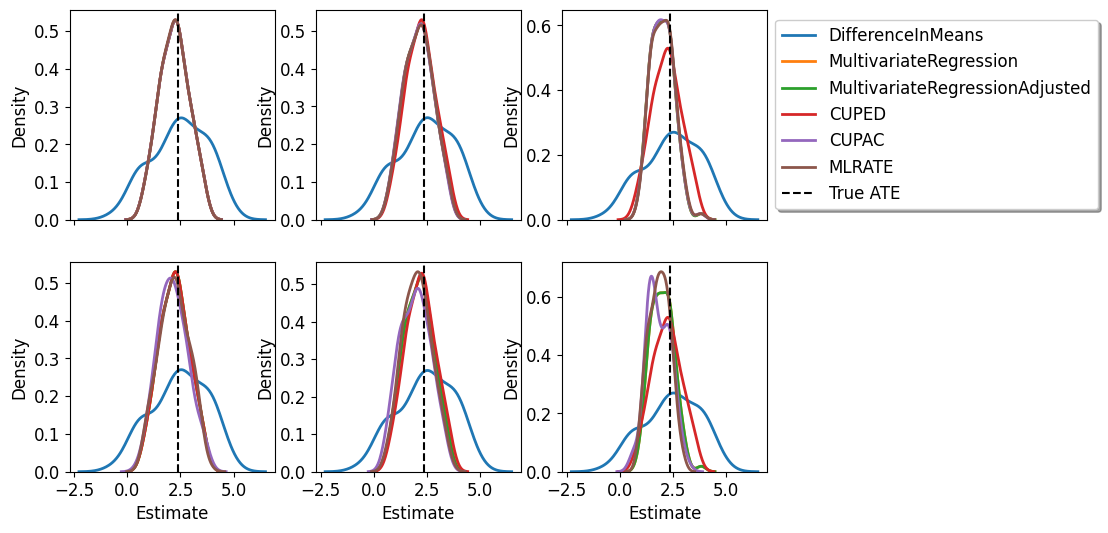

In [23]:
all_evaluation_grid.plot_grid()